In [1]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

     |████████████████████████████████| 1.3 MB 30.9 MB/s            
     |████████████████████████████████| 9.8 MB 117.7 MB/s            
     |████████████████████████████████| 297 kB 116.4 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.0 MB 32.1 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 193.6 MB 194 kB/s              
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.2 MB 31.7 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns         
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

Matplotlib is building the font cache; this may take a moment.


In [12]:
df = pd.read_csv('/mnt/Datasets/merged_df_1_27_23.csv').drop(columns = ['Unnamed: 0'])

df_macros = pd.read_excel('/mnt/Datasets/Lat_long_Field_Map_Macrozones _information.xlsx')
df_macros = df_macros.rename(columns = {'mpz_id': 'Macrozone', 'feature_id': 'Field_Name'})

df = df.merge(df_macros[['Field_Name', 'Macrozone']], how = 'left', on = 'Field_Name')

df = df[(df['Field_Name'] != 'M6V2089') & (df['Field_Name'] != 'M6V2090') & \
       (df['Field_Name'] != 'M6I21001') & (df['Field_Name'] != 'M6I21002') & \
       (df['Field_Name'] != 'M6I21003') & (df['Field_Name'] != 'M6I21203')]

df['N_Total_kg_per_Ha'] = df['N_as_Urea_kg_per_Ha'] + df['N_as_Nitrate_kg_per_Ha'] + df['N_as_Ammonium_kg_per_Ha']
df['P_Total_kg_per_Ha'] = df['P_as_Phosphorus_kg_per_Ha'] + df['P_as_P2O5_kg_per_Ha']
df['K_Total_kg_per_Ha'] = df['K_as_Potassium_kg_per_Ha'] + df['K_as_K2O_kg_per_Ha']

df = df.drop(columns = ['N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha', 'Total_Water_Applied_mm'])

print(display(df))

# df.to_csv('/mnt/Datasets/df_macrozone_merge_2_3_23.csv')

Field_Name  CO2_kg_per_Ha  Crop_Protection_Application_Doses  \
0      M6I2035        -220.35                               14.0   
1      M6I2036        3847.21                               18.0   
2      M6I2037         415.52                               13.0   
3      M6I2009         724.51                                9.0   
4      M6I2010         502.10                                9.0   
..         ...            ...                                ...   
915   M6I21197        -239.89                               15.0   
916   M6I21199         314.80                               17.0   
917   M6I21200        -312.82                               19.0   
918   M6I21201         485.73                               17.0   
919   M6I21202        -522.49                               18.0   

     Soil_Organic_Matter  Yield_kg_per_Ha  Macrozone  N_Total_kg_per_Ha  \
0               2.500000      3003.333333         17             205.50   
1               2.500000      2327.722222         15             246.00   
2               2.500000      3051.800000         17             198.00   
3               2.500000      3732.777778         14             201.85   
4               2.500000      3919.272727         14             178.85   
..                   ...              ...        ...                ...   
915             2.597851      2592.048193         17              92.00   
916             3.120000      3725.967742         22              92.00   
917             2.930000      3726.000000         22              92.00   
918             3.240000      4002.000000         22             207.00   
919             4.250000      3417.615385         22              92.00   

     P_Total_kg_per_Ha  K_Total_kg_per_Ha  
0                 48.0               48.0  
1                108.0              108.0  
2                 60.0               60.0  
3                 92.6               96.0  
4                 92.6               90.0  
..                 ...                ...  
915                0.0                0.0  
916                0.0                0.0  
917                0.0                0.0  
918                0.0                0.0  
919                0.0                0.0  

[920 rows x 9 columns]

None


In [13]:
df = df[df['CO2_kg_per_Ha'] < 0].reset_index(drop = True)
df['Yield_to_CO2_Ratio'] = df['Yield_kg_per_Ha'] / df['CO2_kg_per_Ha']
df['Macrozone'] = df['Macrozone'].astype(str)
df.to_csv('/mnt/Datasets/Brazil_negative_CO2_values_only.csv')
print(display(df))

Field_Name  CO2_kg_per_Ha  Crop_Protection_Application_Doses  \
0      M6I2035        -220.35                               14.0   
1      M6V2017        -246.74                               14.0   
2      M6V2074       -1118.18                               15.0   
3      M6V2075       -1069.08                               15.0   
4      M6V2076        -611.26                               15.0   
..         ...            ...                                ...   
264    M7I2192        -113.13                               15.0   
265   M6I21190        -648.15                               18.0   
266   M6I21197        -239.89                               15.0   
267   M6I21200        -312.82                               19.0   
268   M6I21202        -522.49                               18.0   

     Soil_Organic_Matter  Yield_kg_per_Ha Macrozone  N_Total_kg_per_Ha  \
0               2.500000      3003.333333        17              205.5   
1               3.690000      4096.560847        22              170.2   
2               3.320000      5116.571429        21               23.0   
3               3.050000      3283.194444        21               23.0   
4               2.620000      5462.833333        21               26.0   
..                   ...              ...       ...                ...   
264             2.800000      2760.007022        22               44.1   
265             4.160000      3116.176471        22              167.0   
266             2.597851      2592.048193        17               92.0   
267             2.930000      3726.000000        22               92.0   
268             4.250000      3417.615385        22               92.0   

     P_Total_kg_per_Ha  K_Total_kg_per_Ha  Yield_to_CO2_Ratio  
0                 48.0               48.0          -13.629831  
1                  0.0                0.0          -16.602743  
2                 75.9                0.0           -4.575803  
3                 75.9                0.0           -3.071047  
4                 85.8                0.0           -8.937004  
..                 ...                ...                 ...  
264                0.0              120.0          -24.396774  
265                0.0               50.0           -4.807801  
266                0.0                0.0          -10.805153  
267                0.0                0.0          -11.911003  
268                0.0                0.0           -6.541016  

[269 rows x 10 columns]

None


In [6]:
print(df['Macrozone'].value_counts())

22    67
21    52
17    46
7     36
20    18
14    13
19    11
15     7
12     5
32     3
23     3
30     3
8      2
29     2
25     1
Name: Macrozone, dtype: int64


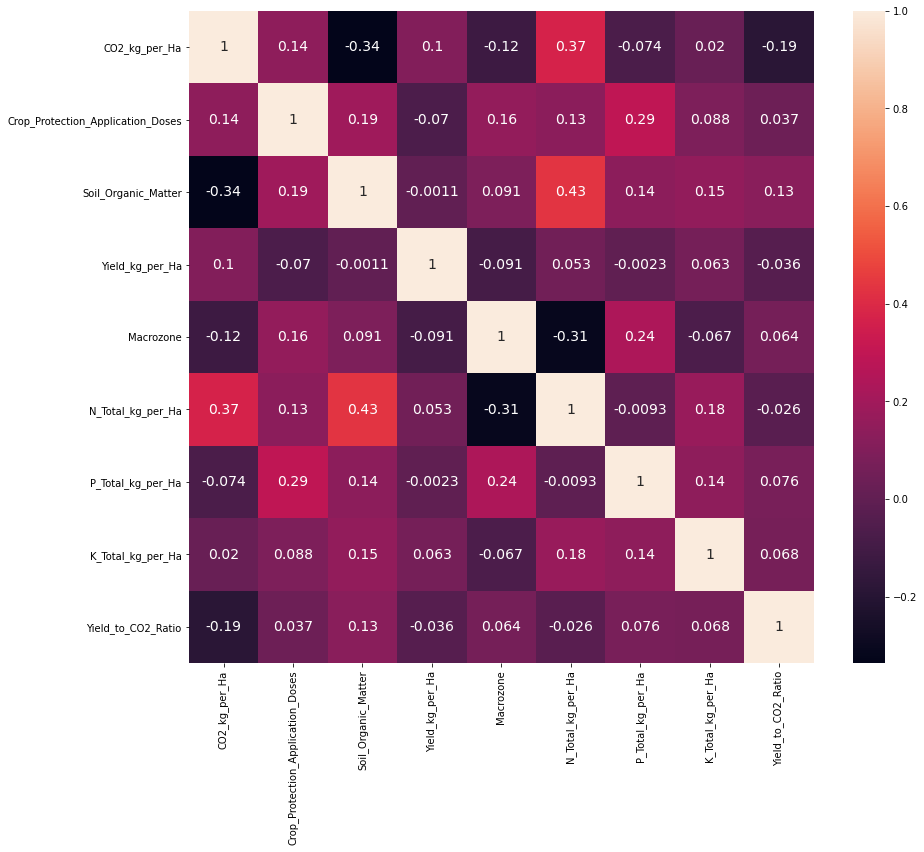

In [7]:
#All Macrozones
corr_matrix = df.corr()
plt.figure(figsize = (14, 12))
sns.heatmap(corr_matrix, annot = True, annot_kws={"fontsize":14})
sns.set(font_scale = 1)
plt.show()

Text(0, 0.5, 'count')

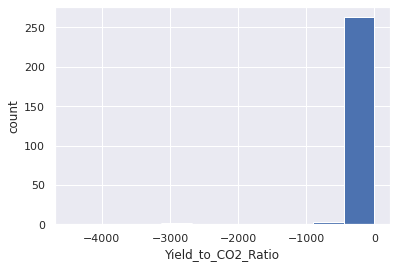

In [11]:
plt.figure()
plt.hist(df['Yield_to_CO2_Ratio'])
plt.xlabel('Yield_to_CO2_Ratio')
plt.ylabel('count')

Text(0, 0.5, 'Yield_kg_per_Ha')

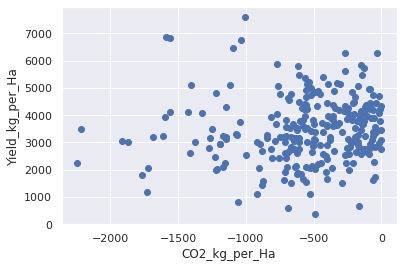

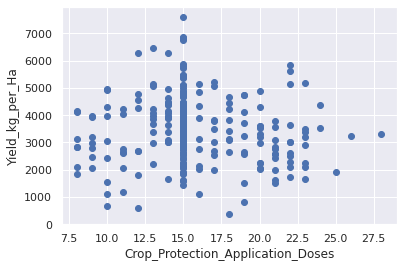

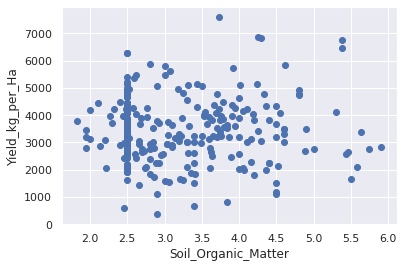

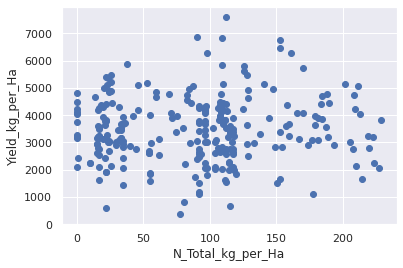

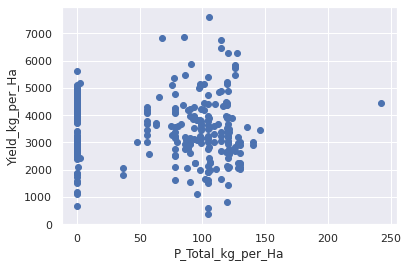

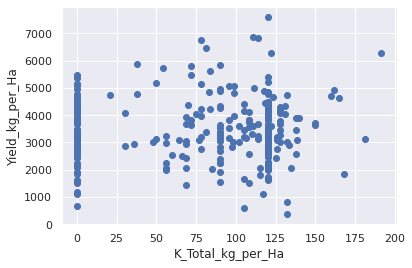

In [8]:
plt.figure()
plt.scatter(df['CO2_kg_per_Ha'], df['Yield_kg_per_Ha'])
plt.xlabel('CO2_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df['Crop_Protection_Application_Doses'], df['Yield_kg_per_Ha'])
plt.xlabel('Crop_Protection_Application_Doses')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df['Soil_Organic_Matter'], df['Yield_kg_per_Ha'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df['N_Total_kg_per_Ha'], df['Yield_kg_per_Ha'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df['P_Total_kg_per_Ha'], df['Yield_kg_per_Ha'])
plt.xlabel('P_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df['K_Total_kg_per_Ha'], df['Yield_kg_per_Ha'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

Text(0, 0.5, 'Yield_to_CO2_Ratio')

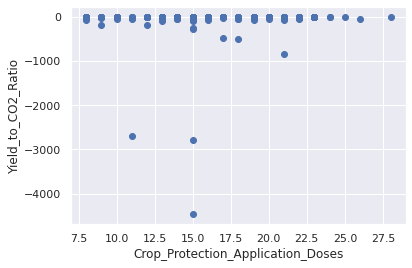

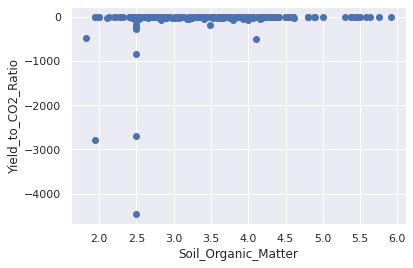

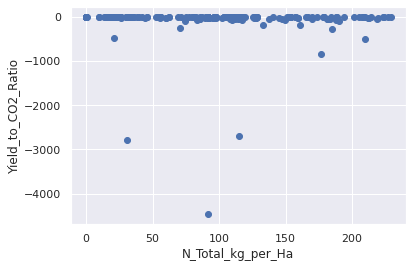

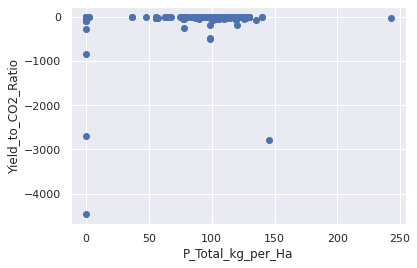

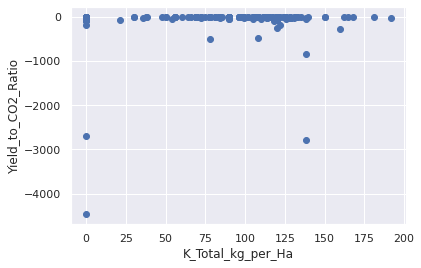

In [10]:
plt.figure()
plt.scatter(df['Crop_Protection_Application_Doses'], df['Yield_to_CO2_Ratio'])
plt.xlabel('Crop_Protection_Application_Doses')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df['Soil_Organic_Matter'], df['Yield_to_CO2_Ratio'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df['N_Total_kg_per_Ha'], df['Yield_to_CO2_Ratio'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df['P_Total_kg_per_Ha'], df['Yield_to_CO2_Ratio'])
plt.xlabel('P_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df['K_Total_kg_per_Ha'], df['Yield_to_CO2_Ratio'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

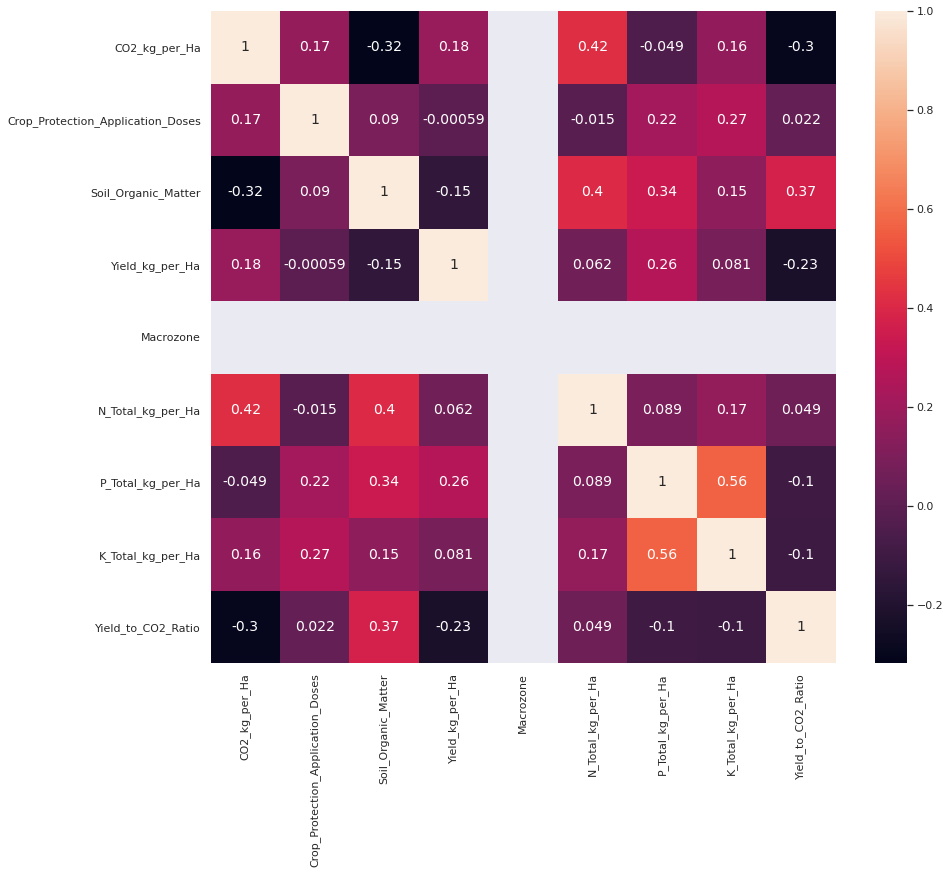

In [7]:
#Macrozone 22
corr_matrix = df[df['Macrozone'] == 22].corr()
plt.figure(figsize = (14, 12))
sns.heatmap(corr_matrix, annot = True, annot_kws={"fontsize":14})
sns.set(font_scale = 1)
plt.show()

Text(0, 0.5, 'Yield_kg_per_Ha')

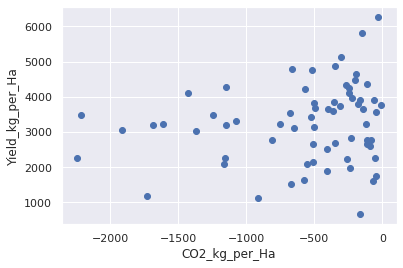

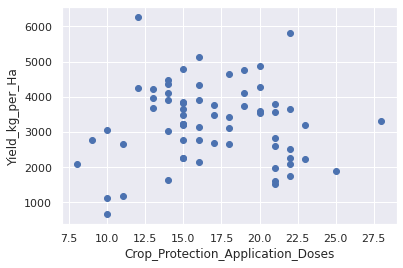

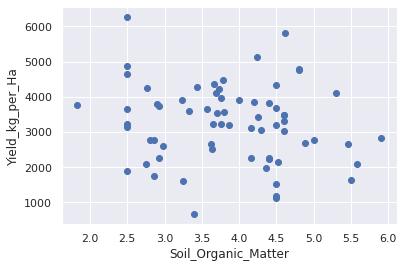

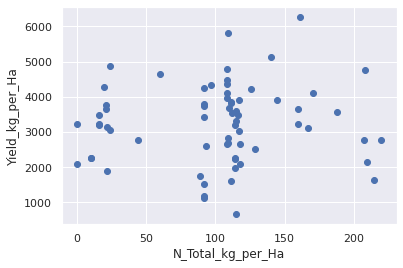

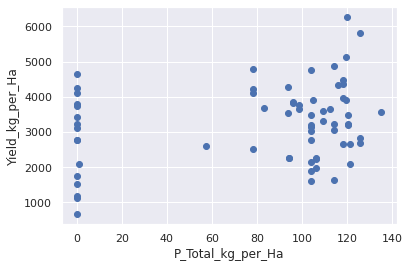

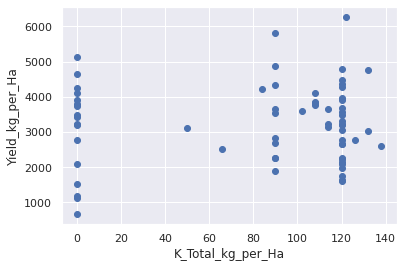

In [9]:
plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['CO2_kg_per_Ha'], df[df['Macrozone'] == 22]['Yield_kg_per_Ha'])
plt.xlabel('CO2_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['Crop_Protection_Application_Doses'], df[df['Macrozone'] == 22]['Yield_kg_per_Ha'])
plt.xlabel('Crop_Protection_Application_Doses')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['Soil_Organic_Matter'], df[df['Macrozone'] == 22]['Yield_kg_per_Ha'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['N_Total_kg_per_Ha'], df[df['Macrozone'] == 22]['Yield_kg_per_Ha'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['P_Total_kg_per_Ha'], df[df['Macrozone'] == 22]['Yield_kg_per_Ha'])
plt.xlabel('P_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['K_Total_kg_per_Ha'], df[df['Macrozone'] == 22]['Yield_kg_per_Ha'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

Text(0, 0.5, 'Yield_to_CO2_Ratio')

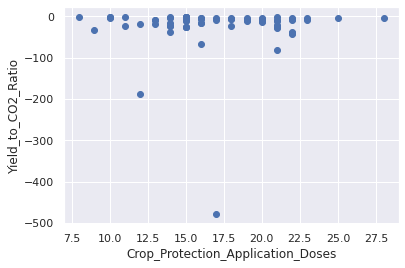

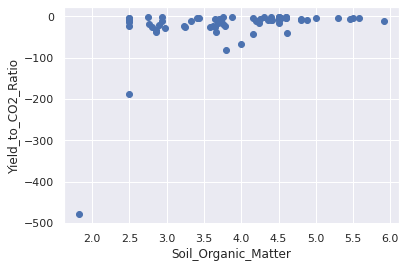

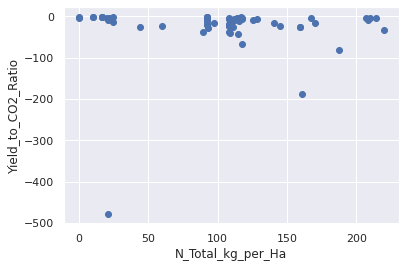

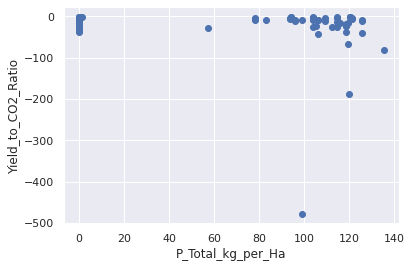

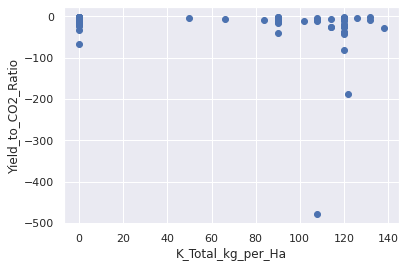

In [9]:
plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['Crop_Protection_Application_Doses'], df[df['Macrozone'] == 22]['Yield_to_CO2_Ratio'])
plt.xlabel('Crop_Protection_Application_Doses')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['Soil_Organic_Matter'], df[df['Macrozone'] == 22]['Yield_to_CO2_Ratio'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['N_Total_kg_per_Ha'], df[df['Macrozone'] == 22]['Yield_to_CO2_Ratio'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['P_Total_kg_per_Ha'], df[df['Macrozone'] == 22]['Yield_to_CO2_Ratio'])
plt.xlabel('P_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 22]['K_Total_kg_per_Ha'], df[df['Macrozone'] == 22]['Yield_to_CO2_Ratio'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

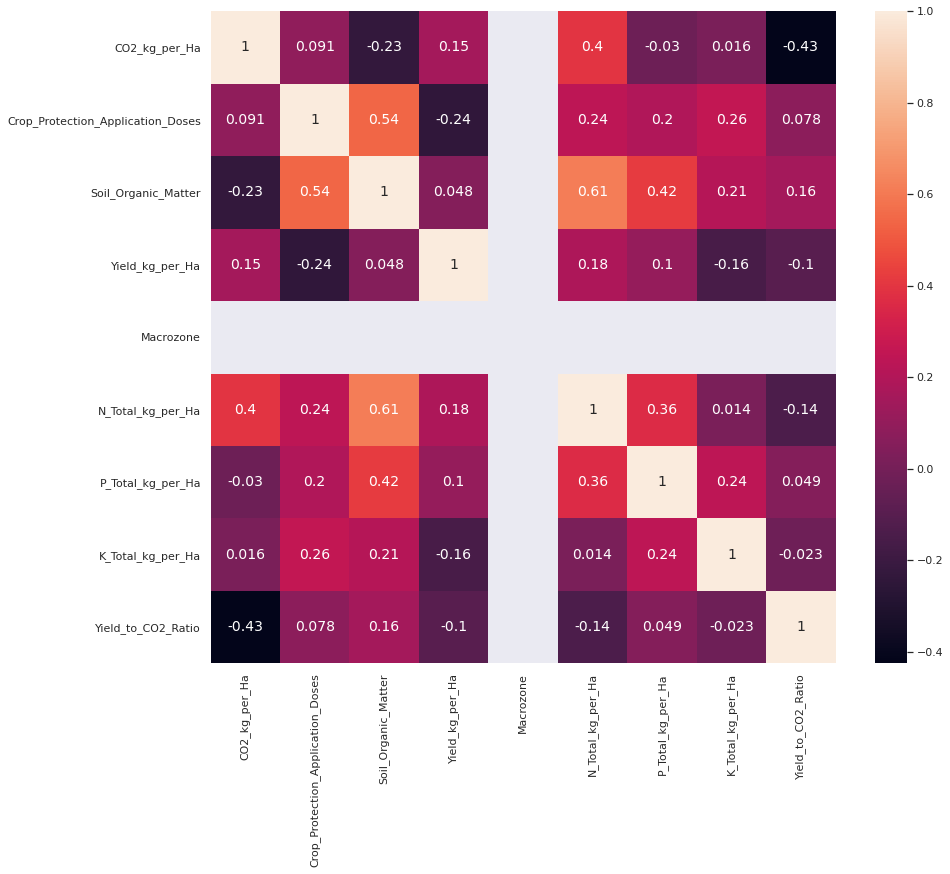

In [10]:
corr_matrix = df[df['Macrozone'] == 21].corr()
plt.figure(figsize = (14, 12))
sns.heatmap(corr_matrix, annot = True, annot_kws={"fontsize":14})
sns.set(font_scale = 1)
plt.show()

Text(0, 0.5, 'Yield_kg_per_Ha')

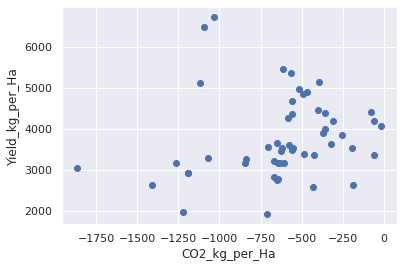

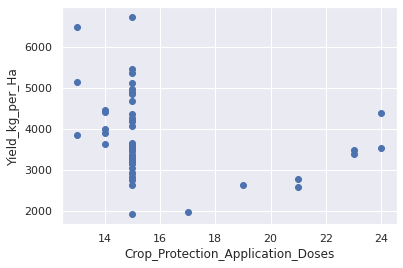

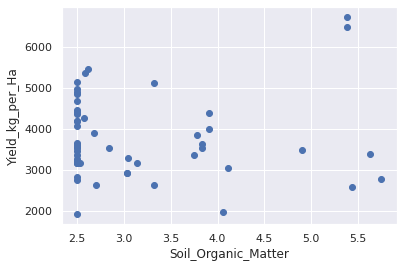

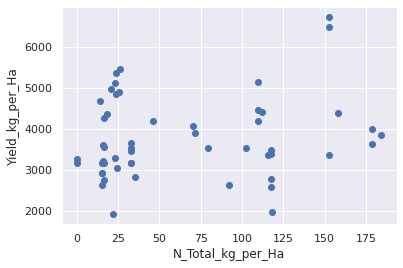

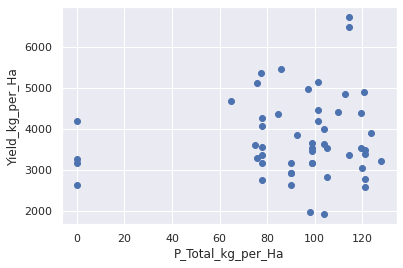

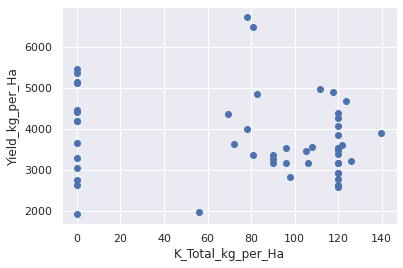

In [11]:
plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['CO2_kg_per_Ha'], df[df['Macrozone'] == 21]['Yield_kg_per_Ha'])
plt.xlabel('CO2_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['Crop_Protection_Application_Doses'], df[df['Macrozone'] == 21]['Yield_kg_per_Ha'])
plt.xlabel('Crop_Protection_Application_Doses')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['Soil_Organic_Matter'], df[df['Macrozone'] == 21]['Yield_kg_per_Ha'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['N_Total_kg_per_Ha'], df[df['Macrozone'] == 21]['Yield_kg_per_Ha'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['P_Total_kg_per_Ha'], df[df['Macrozone'] == 21]['Yield_kg_per_Ha'])
plt.xlabel('P_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['K_Total_kg_per_Ha'], df[df['Macrozone'] == 21]['Yield_kg_per_Ha'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_kg_per_Ha')

Text(0, 0.5, 'Yield_to_CO2_Ratio')

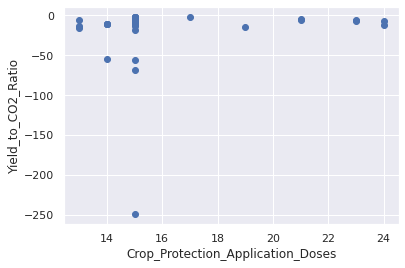

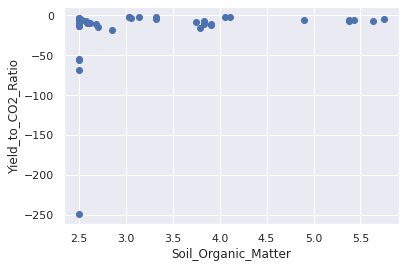

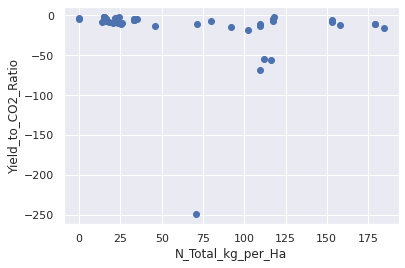

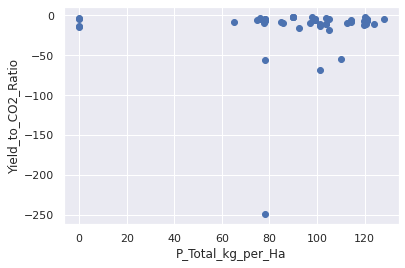

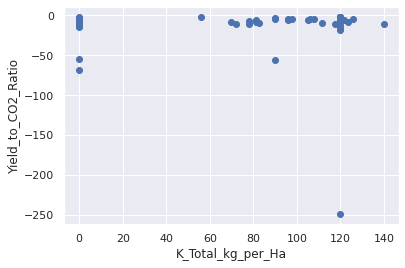

In [12]:
plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['Crop_Protection_Application_Doses'], df[df['Macrozone'] == 21]['Yield_to_CO2_Ratio'])
plt.xlabel('Crop_Protection_Application_Doses')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['Soil_Organic_Matter'], df[df['Macrozone'] == 21]['Yield_to_CO2_Ratio'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['N_Total_kg_per_Ha'], df[df['Macrozone'] == 21]['Yield_to_CO2_Ratio'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['P_Total_kg_per_Ha'], df[df['Macrozone'] == 21]['Yield_to_CO2_Ratio'])
plt.xlabel('P_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure()
plt.scatter(df[df['Macrozone'] == 21]['K_Total_kg_per_Ha'], df[df['Macrozone'] == 21]['Yield_to_CO2_Ratio'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

In [2]:
!pip install shap
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

     |████████████████████████████████| 575 kB 31.1 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


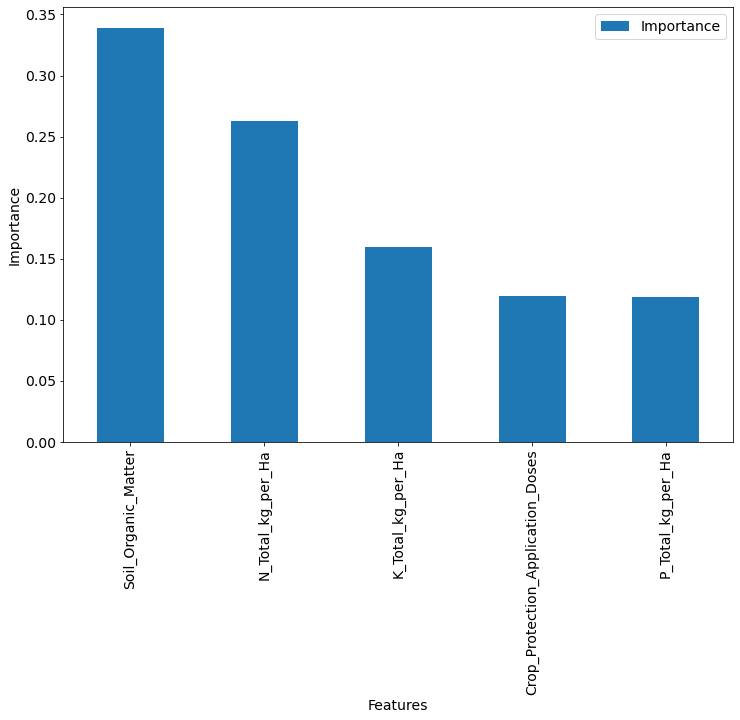

Feature  \
Feature                                                                
Soil_Organic_Matter                              Soil_Organic_Matter   
N_Total_kg_per_Ha                                  N_Total_kg_per_Ha   
K_Total_kg_per_Ha                                  K_Total_kg_per_Ha   
Crop_Protection_Application_Doses  Crop_Protection_Application_Doses   
P_Total_kg_per_Ha                                  P_Total_kg_per_Ha   

                                   Importance  
Feature                                        
Soil_Organic_Matter                  0.339014  
N_Total_kg_per_Ha                    0.262456  
K_Total_kg_per_Ha                    0.159647  
Crop_Protection_Application_Doses    0.119867  
P_Total_kg_per_Ha                    0.119016

None


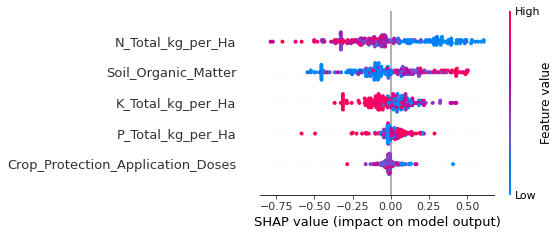

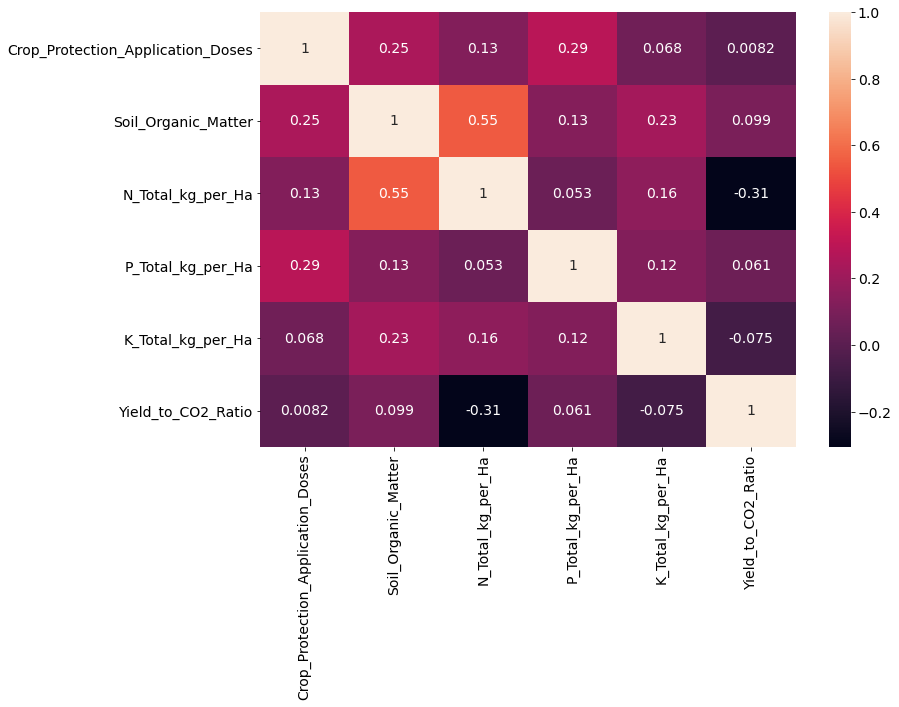

215


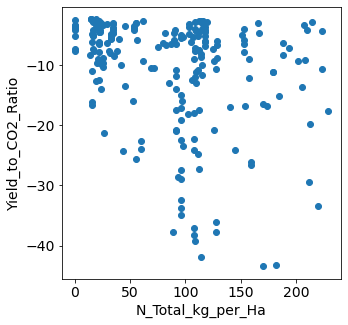

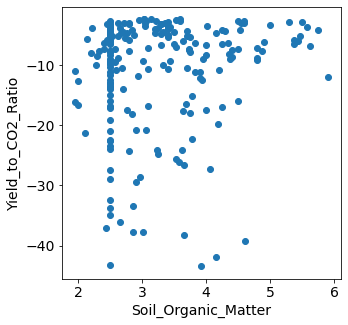

In [33]:
#Random Forest Classifier Feature Importance
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

# Load the dataset
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.9
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)]

#___________

h=["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]
df0_filtered=df0_filtered[h]

# Normalize data

# copy the data
df_z_scaled = df0_filtered.copy()

y_std = df_z_scaled['Yield_to_CO2_Ratio'].std()
y_mean = df_z_scaled['Yield_to_CO2_Ratio'].mean()

# apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()   

# Split the data into features and target variable
X = df_z_scaled.drop("Yield_to_CO2_Ratio", axis=1)
y = df_z_scaled["Yield_to_CO2_Ratio"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
features = X.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print the top 10 most important features
ar=importance_df.head(5)
ar.index = ar['Feature']
ar.plot.bar()
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
print(display(ar))

# Regression
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)

# Fit the Model
model.fit(X, y)
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
i = 5
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Correlation Matrix
corr_matrix = df_z_scaled.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['N_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')


plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['Soil_Organic_Matter'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_to_CO2_Ratio')

print(len(df_z_scaled))

In [19]:
#Exhaustive Feature Selection
from mlxtend.feature_selection import ExhaustiveFeatureSelector

from sklearn.ensemble import RandomForestRegressor

#random forest
efs = ExhaustiveFeatureSelector(RandomForestRegressor(),min_features = 2, max_features = 5, scoring='neg_mean_squared_error', cv = 2)
efs = efs.fit(X,y)
selected_features = X.columns[list(efs.best_idx_)]
print(selected_features)

#xgboost
efs = ExhaustiveFeatureSelector(XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001),min_features = 2, max_features = 5, scoring='neg_mean_squared_error', cv = 2)
efs = efs.fit(X,y)
selected_features = X.columns[list(efs.best_idx_)]
print(selected_features)

Features: 26/26

Index(['Soil_Organic_Matter', 'N_Total_kg_per_Ha', 'K_Total_kg_per_Ha'], dtype='object')


Features: 26/26

Index(['Crop_Protection_Application_Doses', 'Soil_Organic_Matter',
       'N_Total_kg_per_Ha', 'P_Total_kg_per_Ha', 'K_Total_kg_per_Ha'],
      dtype='object')


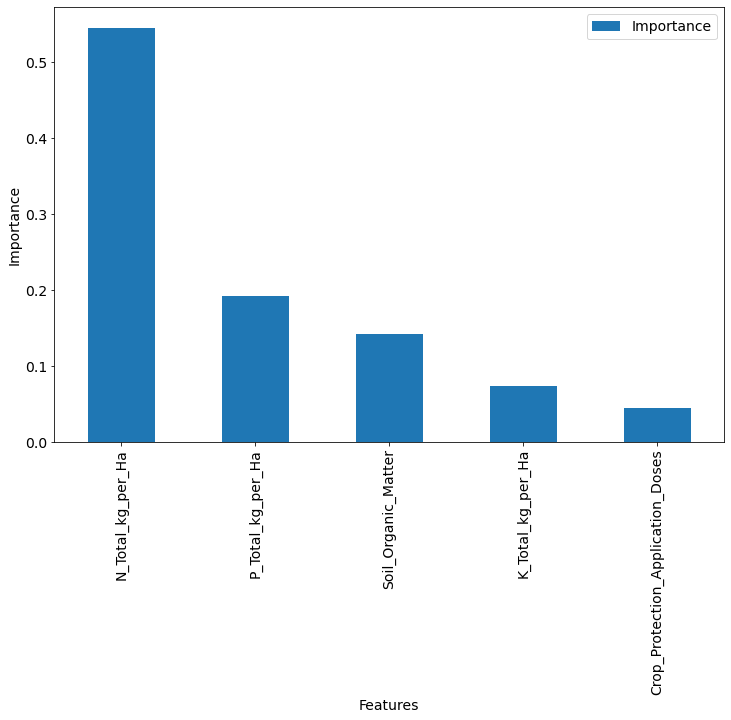

Feature  \
Feature                                                                
N_Total_kg_per_Ha                                  N_Total_kg_per_Ha   
P_Total_kg_per_Ha                                  P_Total_kg_per_Ha   
Soil_Organic_Matter                              Soil_Organic_Matter   
K_Total_kg_per_Ha                                  K_Total_kg_per_Ha   
Crop_Protection_Application_Doses  Crop_Protection_Application_Doses   

                                   Importance  
Feature                                        
N_Total_kg_per_Ha                    0.545371  
P_Total_kg_per_Ha                    0.192633  
Soil_Organic_Matter                  0.142629  
K_Total_kg_per_Ha                    0.074220  
Crop_Protection_Application_Doses    0.045147

None


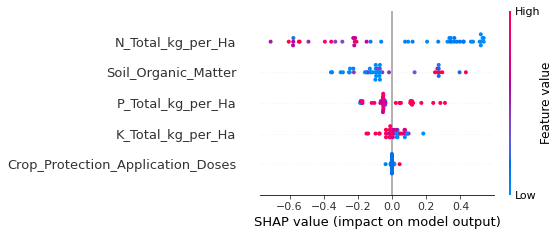

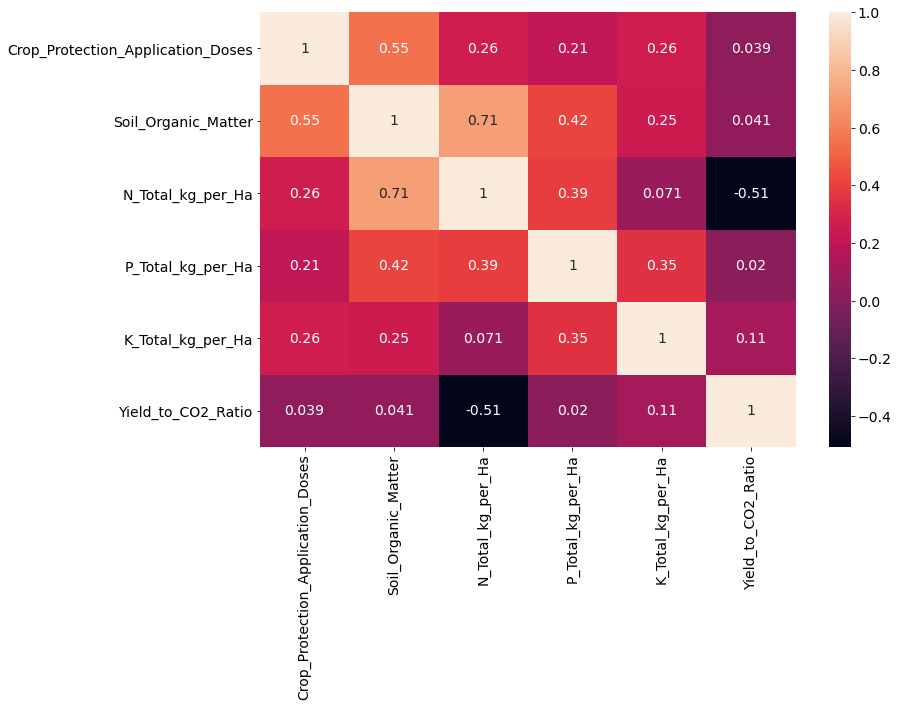

45


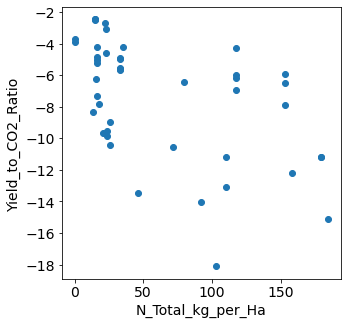

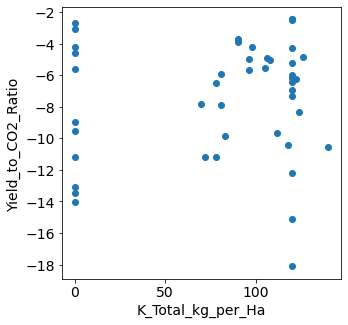

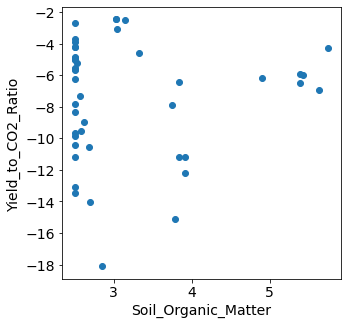

In [34]:
#Macrozone 21

# Load the dataset
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.9
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)].reset_index(drop = True)
df0_filtered = df0_filtered[df0_filtered['Macrozone'] == 21].reset_index(drop = True)
df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

# Normalize data

# copy the data
df_z_scaled = df0_filtered.copy()

y_std = df0_filtered['Yield_to_CO2_Ratio'].std()
y_mean = df0_filtered['Yield_to_CO2_Ratio'].mean()

# apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()   

# Split the data into features and target variable
X = df_z_scaled.drop("Yield_to_CO2_Ratio", axis=1)
y = df_z_scaled["Yield_to_CO2_Ratio"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
features = X.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print the top 10 most important features
ar=importance_df.head(5)
ar.index = ar['Feature']
ar.plot.bar()
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
print(display(ar))

# Regression
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)

# Fit the Model
model.fit(X, y)
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
i = 5
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Correlation Matrix
corr_matrix = df_z_scaled.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['N_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['K_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['Soil_Organic_Matter'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_to_CO2_Ratio')
print(len(df_z_scaled))

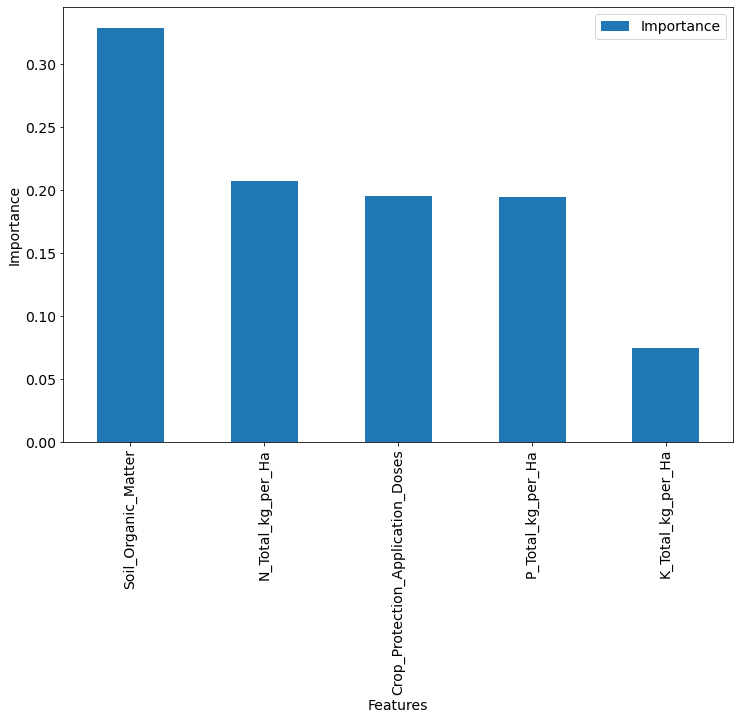

Feature  \
Feature                                                                
Soil_Organic_Matter                              Soil_Organic_Matter   
N_Total_kg_per_Ha                                  N_Total_kg_per_Ha   
Crop_Protection_Application_Doses  Crop_Protection_Application_Doses   
P_Total_kg_per_Ha                                  P_Total_kg_per_Ha   
K_Total_kg_per_Ha                                  K_Total_kg_per_Ha   

                                   Importance  
Feature                                        
Soil_Organic_Matter                  0.328678  
N_Total_kg_per_Ha                    0.207099  
Crop_Protection_Application_Doses    0.195274  
P_Total_kg_per_Ha                    0.194268  
K_Total_kg_per_Ha                    0.074679

None


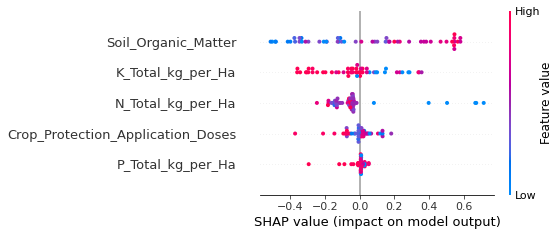

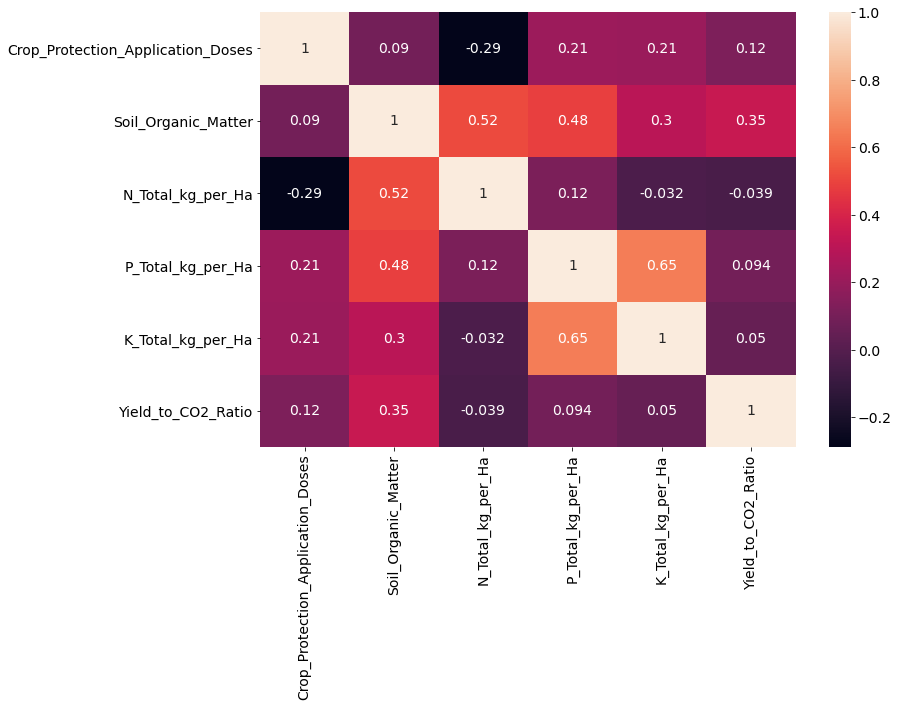

52


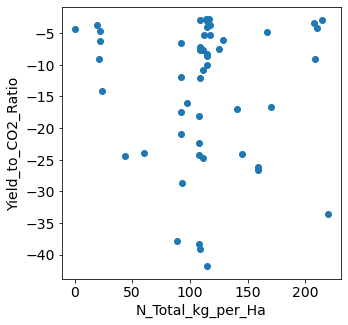

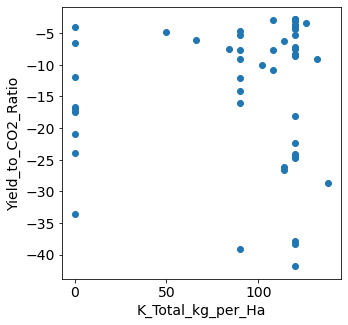

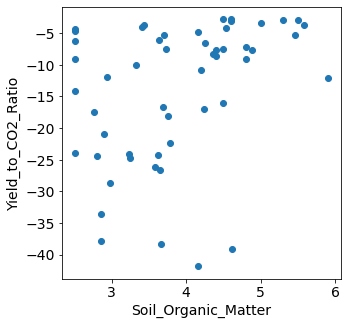

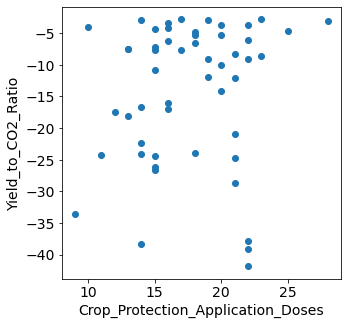

In [41]:
#Macrozone 22

# Load the dataset
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.9
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)].reset_index(drop = True)
df0_filtered = df0_filtered[df0_filtered['Macrozone'] == 22].reset_index(drop = True)
df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

# Normalize data

# copy the data
df_z_scaled = df0_filtered.copy()

y_std = df0_filtered['Yield_to_CO2_Ratio'].std()
y_mean = df0_filtered['Yield_to_CO2_Ratio'].mean()

# apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()   


# Split the data into features and target variable
X = df_z_scaled.drop("Yield_to_CO2_Ratio", axis=1)
y = df_z_scaled["Yield_to_CO2_Ratio"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
features = X.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print the top 10 most important features
ar=importance_df.head(5)
ar.index = ar['Feature']
ar.plot.bar()
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
print(display(ar))

# Regression
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)

# Fit the Model
model.fit(X, y)
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
i = 5
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Correlation Matrix
corr_matrix = df_z_scaled.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['N_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['K_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['Soil_Organic_Matter'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_to_CO2_Ratio')

plt.figure(figsize=(5,5))
plt.scatter(df0_filtered['Crop_Protection_Application_Doses'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('Crop_Protection_Application_Doses')
plt.ylabel('Yield_to_CO2_Ratio')

print(len(df_z_scaled))

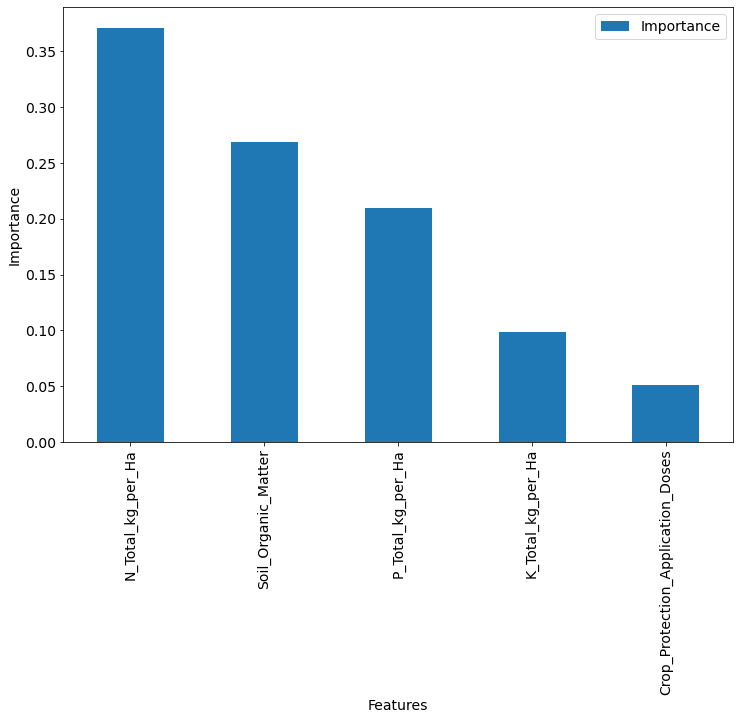

Feature  \
Feature                                                                
N_Total_kg_per_Ha                                  N_Total_kg_per_Ha   
Soil_Organic_Matter                              Soil_Organic_Matter   
P_Total_kg_per_Ha                                  P_Total_kg_per_Ha   
K_Total_kg_per_Ha                                  K_Total_kg_per_Ha   
Crop_Protection_Application_Doses  Crop_Protection_Application_Doses   

                                   Importance  
Feature                                        
N_Total_kg_per_Ha                    0.371079  
Soil_Organic_Matter                  0.269264  
P_Total_kg_per_Ha                    0.209933  
K_Total_kg_per_Ha                    0.098275  
Crop_Protection_Application_Doses    0.051450

None


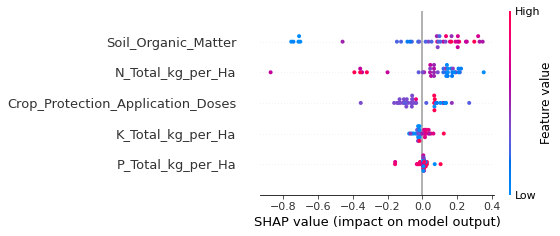

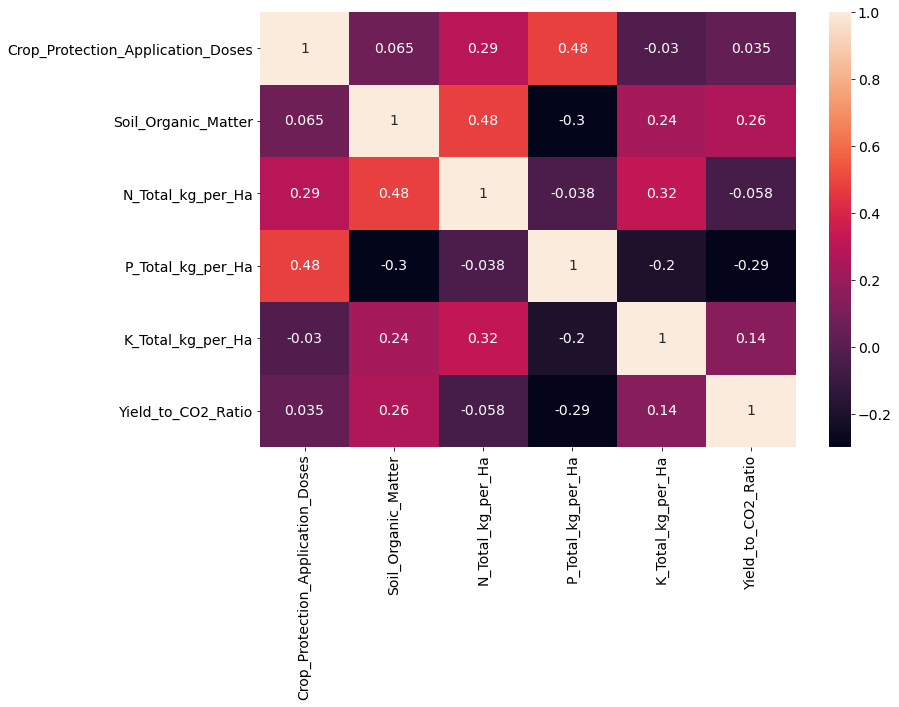

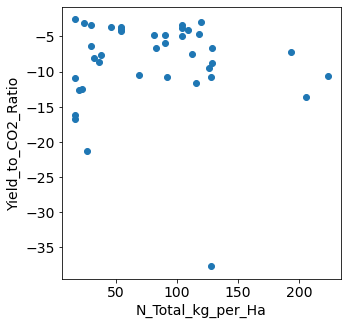

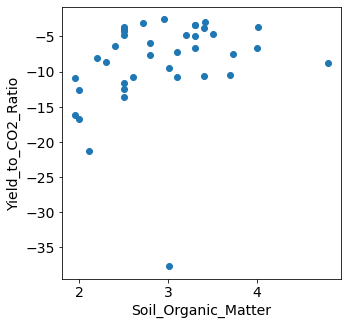

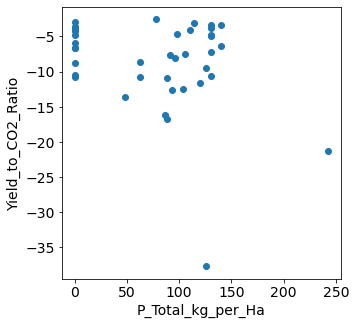

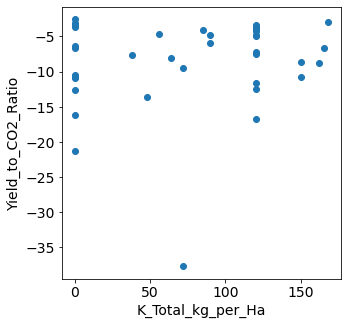

39


In [42]:
#Macrozone 17

# Load the dataset
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.9
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)].reset_index(drop = True)
df0_filtered = df0_filtered[df0_filtered['Macrozone'] == 17].reset_index(drop = True)
df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

# Normalize data

# copy the data
df_z_scaled = df0_filtered.copy()

y_std = df0_filtered['Yield_to_CO2_Ratio'].std()
y_mean = df0_filtered['Yield_to_CO2_Ratio'].mean()

# apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()   

# Split the data into features and target variable
X = df_z_scaled.drop("Yield_to_CO2_Ratio", axis=1)
y = df_z_scaled["Yield_to_CO2_Ratio"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
features = X.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print the top 10 most important features
ar=importance_df.head(5)
ar.index = ar['Feature']
ar.plot.bar()
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
print(display(ar))

# Regression
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)

# Fit the Model
model.fit(X, y)
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
i = 5
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Correlation Matrix
corr_matrix = df_z_scaled.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

plt.figure(figsize = (5,5))
plt.scatter(df0_filtered['N_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('N_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')
plt.show()

plt.figure(figsize = (5,5))
plt.scatter(df0_filtered['Soil_Organic_Matter'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('Soil_Organic_Matter')
plt.ylabel('Yield_to_CO2_Ratio')
plt.show()

plt.figure(figsize = (5,5))
plt.scatter(df0_filtered['P_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('P_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')
plt.show()

plt.figure(figsize = (5,5))
plt.scatter(df0_filtered['K_Total_kg_per_Ha'], df0_filtered['Yield_to_CO2_Ratio'])
plt.xlabel('K_Total_kg_per_Ha')
plt.ylabel('Yield_to_CO2_Ratio')
plt.show()

print(len(df0_filtered))

In [24]:
import os
import pandas as pd
import scipy as sp
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[17:53:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 7.134090555553038


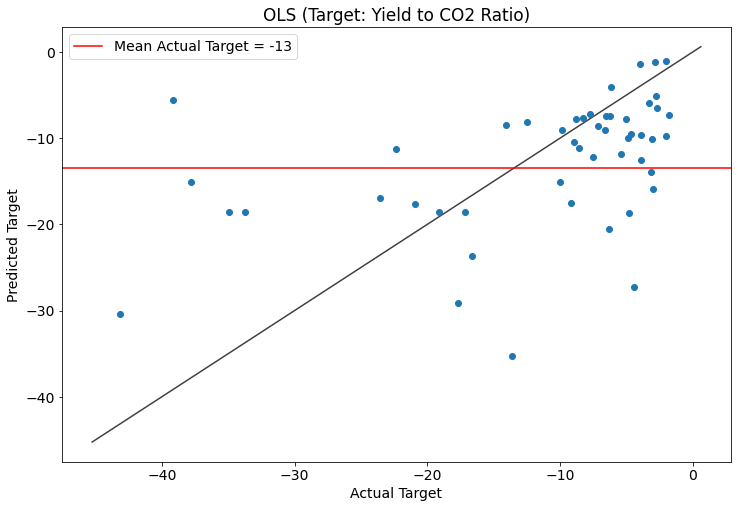

Lasso
MAE on test data: 7.1277239107277826


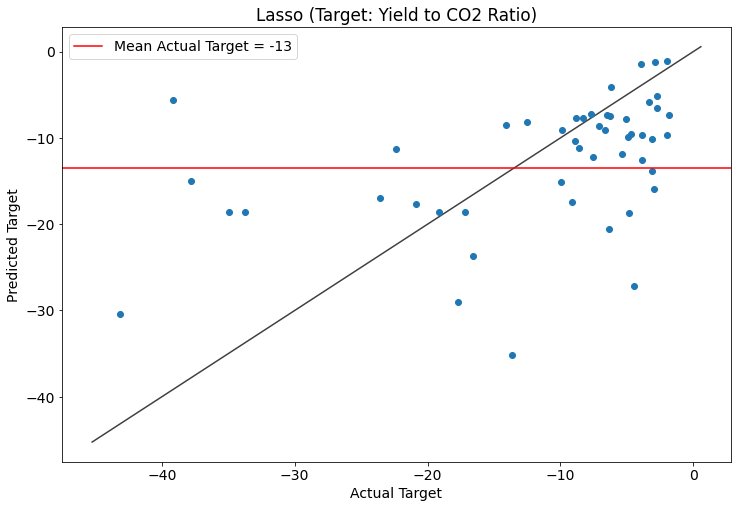

Ridge
MAE on test data: 7.106962683968361


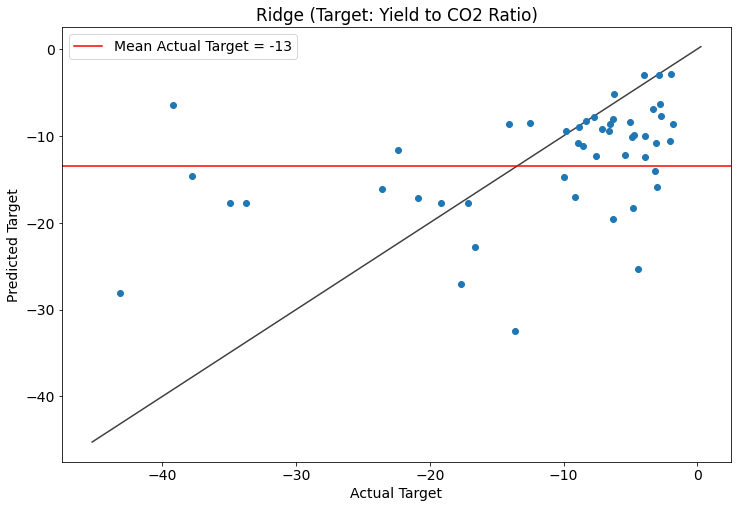

ElasticNet
MAE on test data: 7.1285221033098045


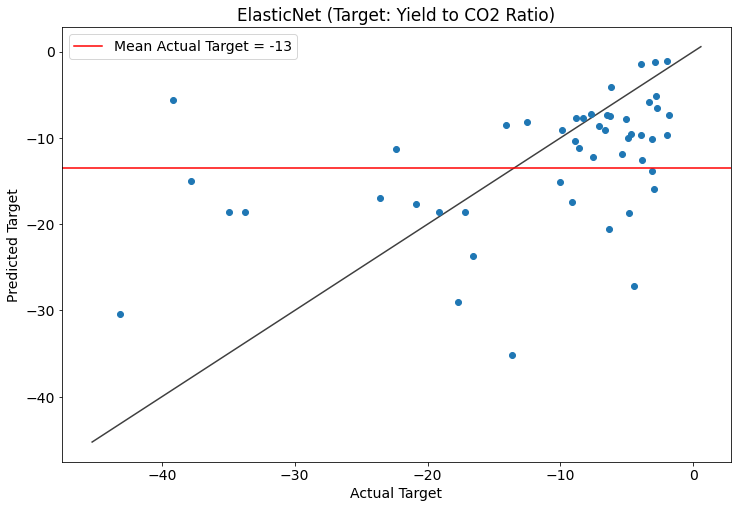

SVR
MAE on test data: 6.291202057316987


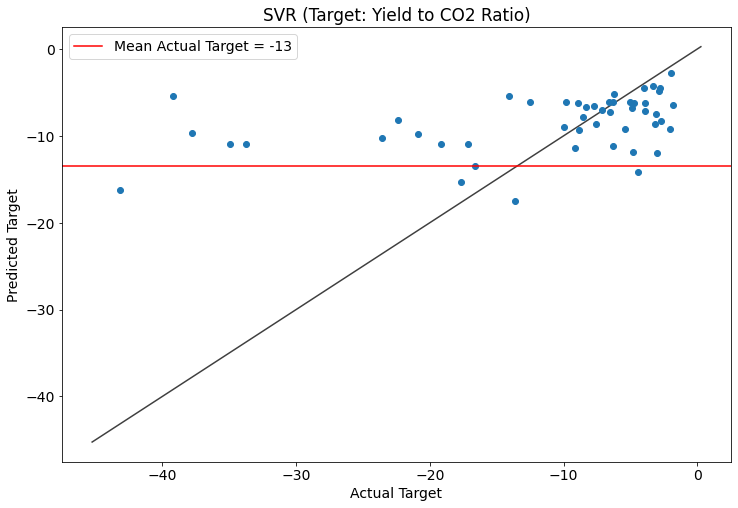

Lightgbm
MAE on test data: 7.635499720507574


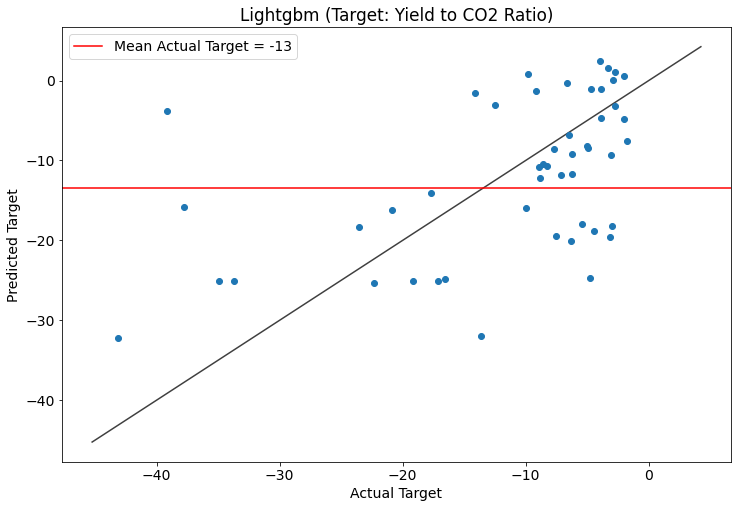

GBR
MAE on test data: 7.0325639362239665


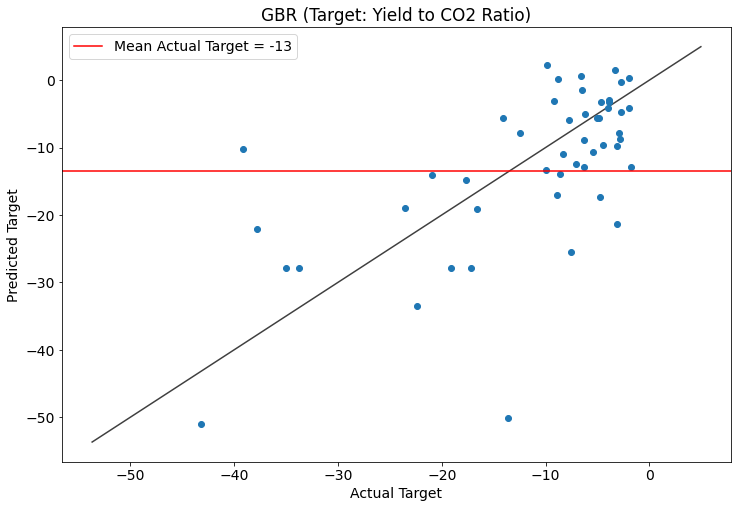

XGBoost
MAE on test data: 6.92941620688011


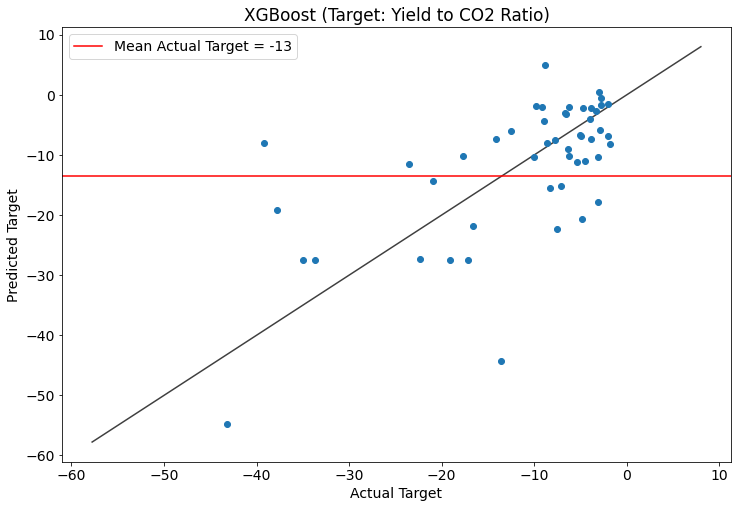

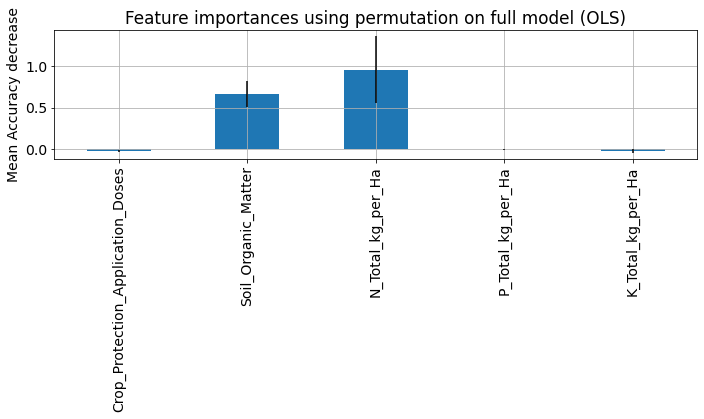

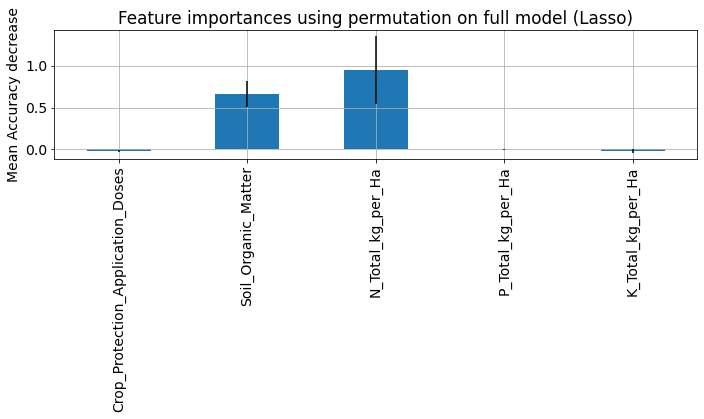

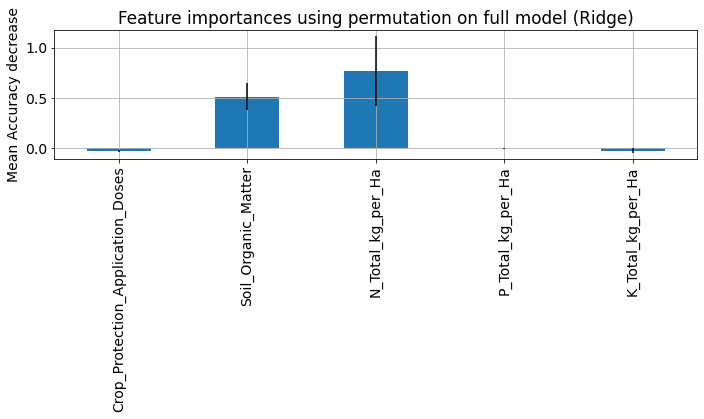

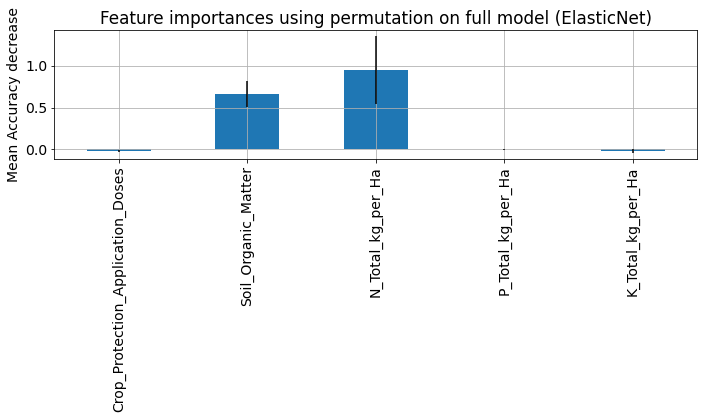

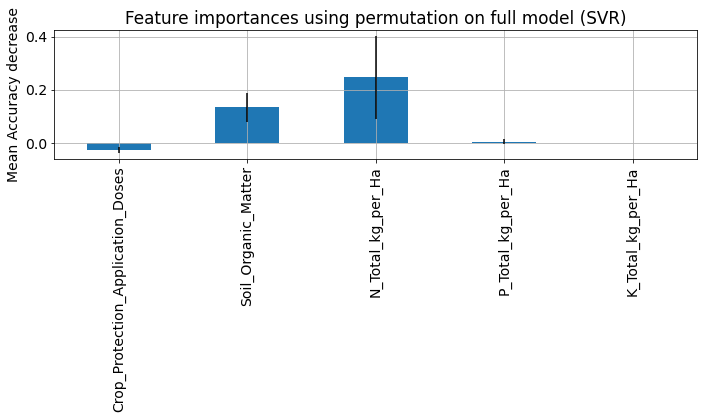

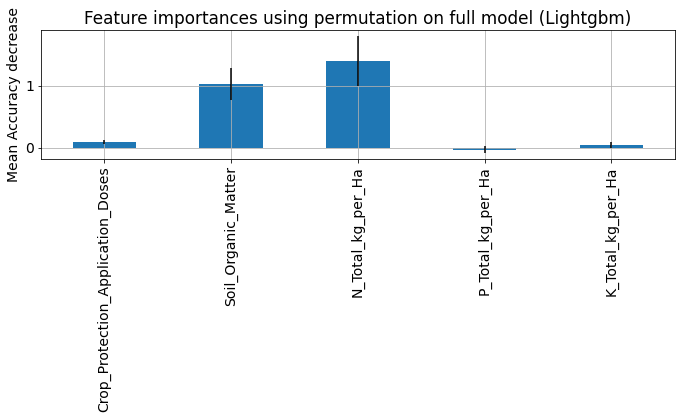

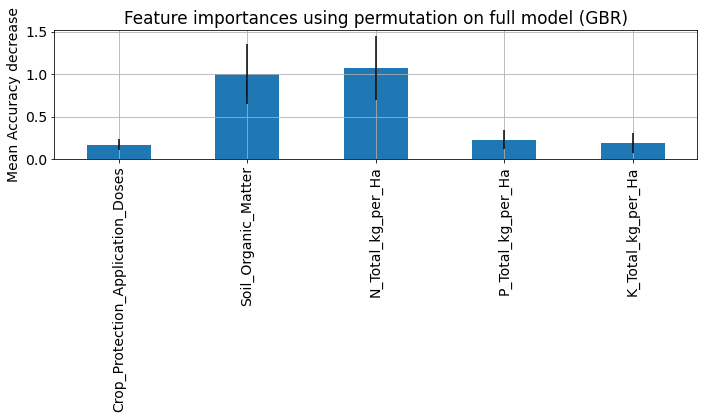

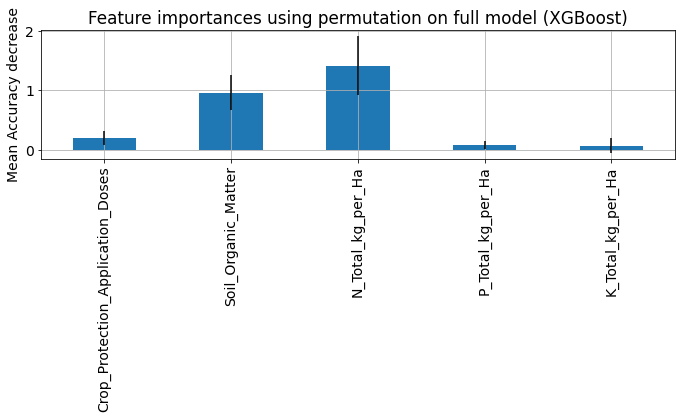

In [36]:
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.95
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)]
df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df0_filtered, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))

for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield to CO2 Ratio)')
    plt.legend()
    plt.show()
    
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[18:37:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 3.4083158009870558


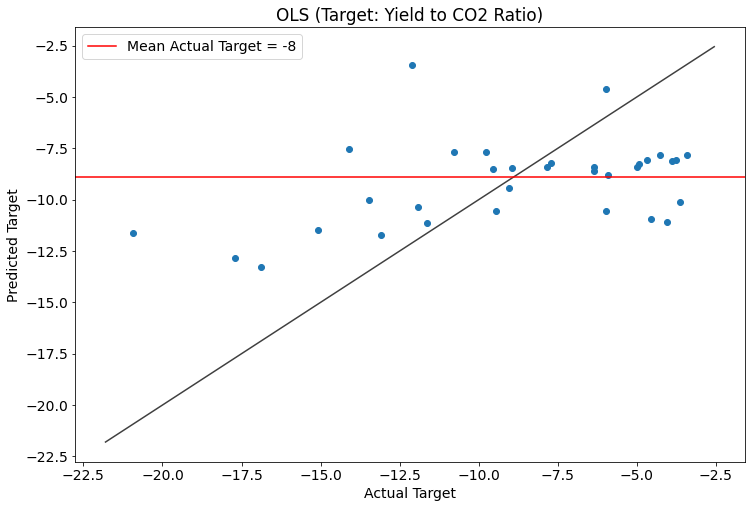

Lasso
MAE on test data: 3.4094059641643795


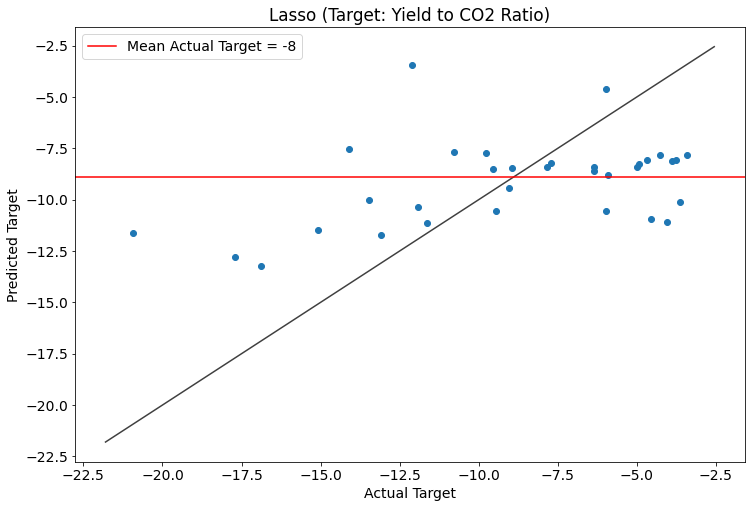

Ridge
MAE on test data: 3.421864995018823


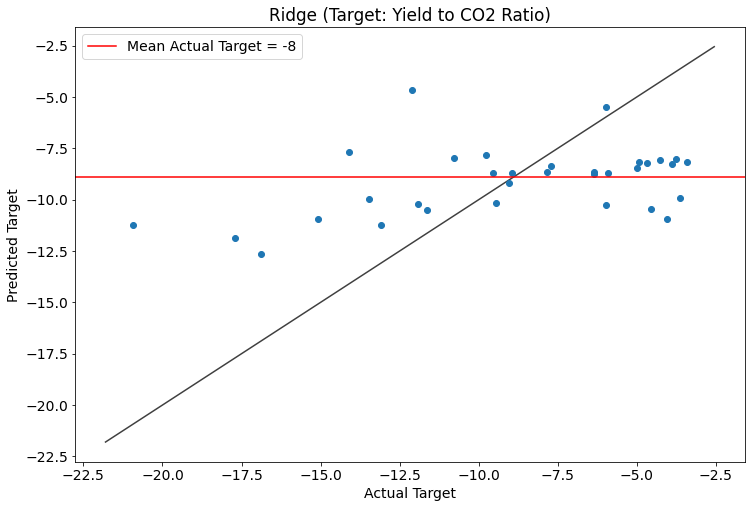

ElasticNet
MAE on test data: 3.4092688950956473


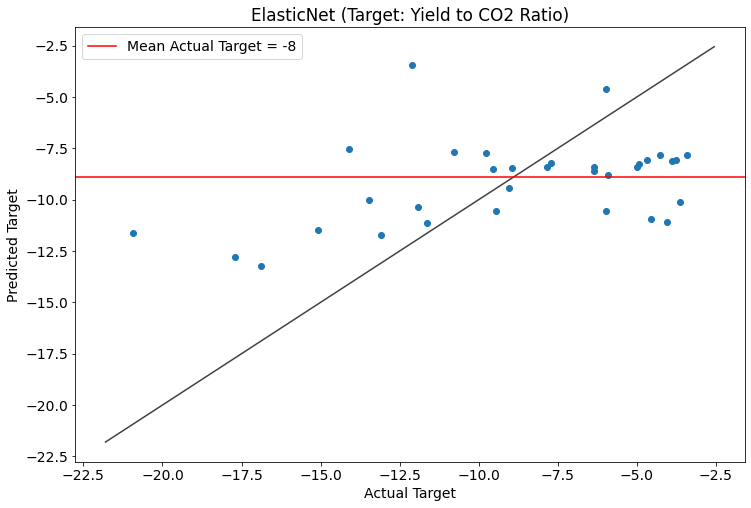

SVR
MAE on test data: 3.550428837221513


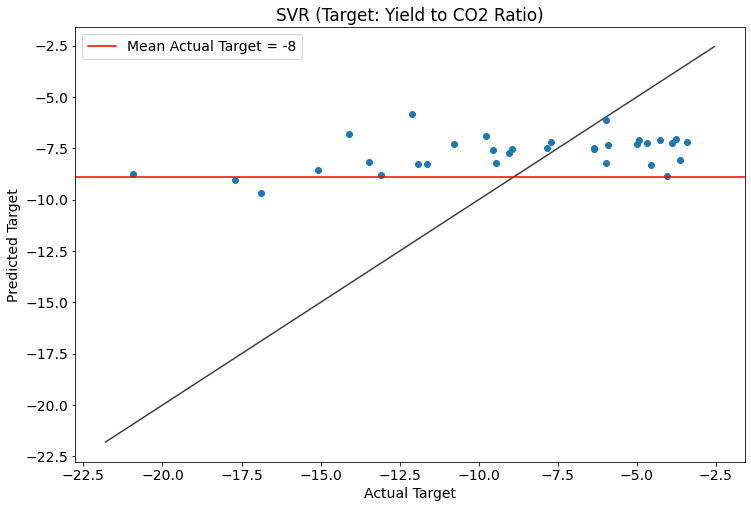

Lightgbm
MAE on test data: 3.255849592302063


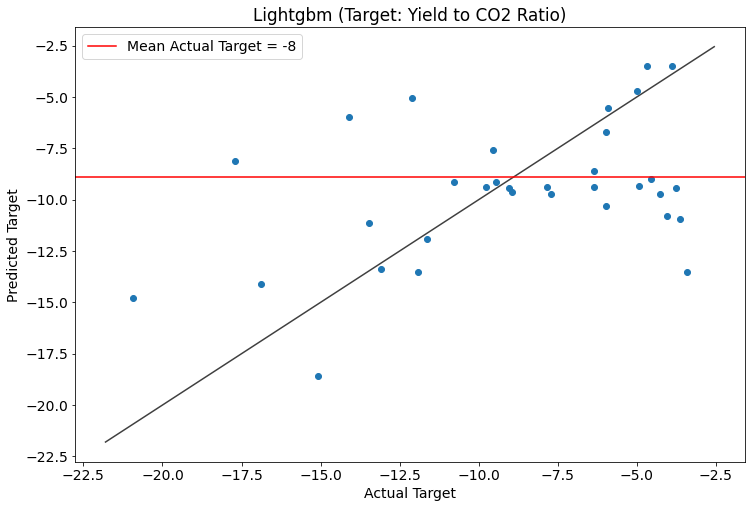

GBR
MAE on test data: 3.8119693175226876


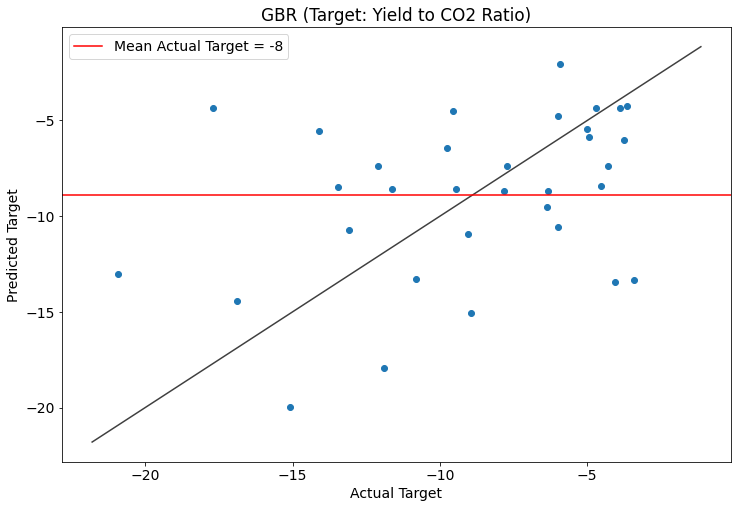

XGBoost
MAE on test data: 3.4339211682104334


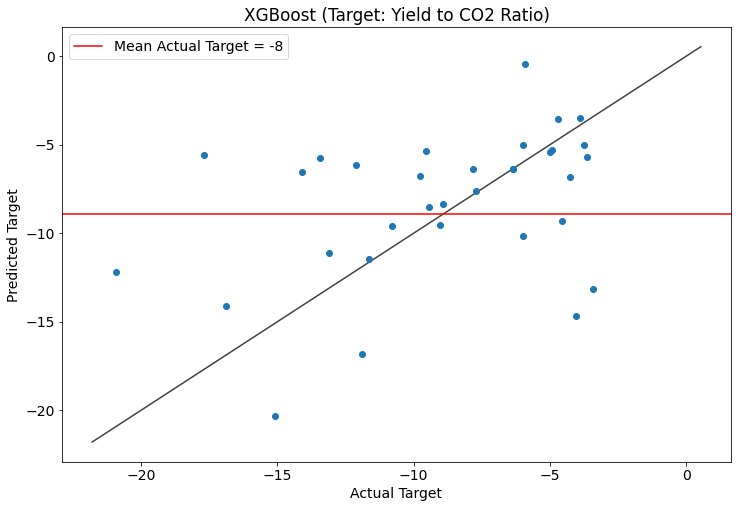

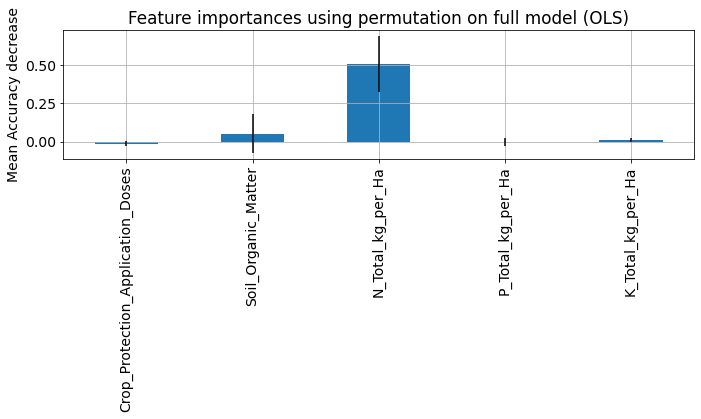

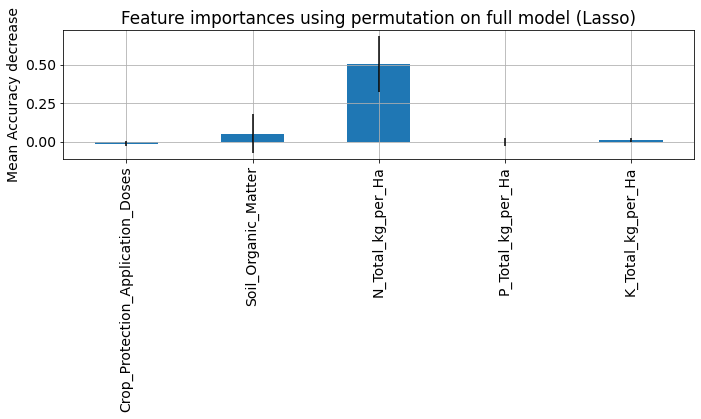

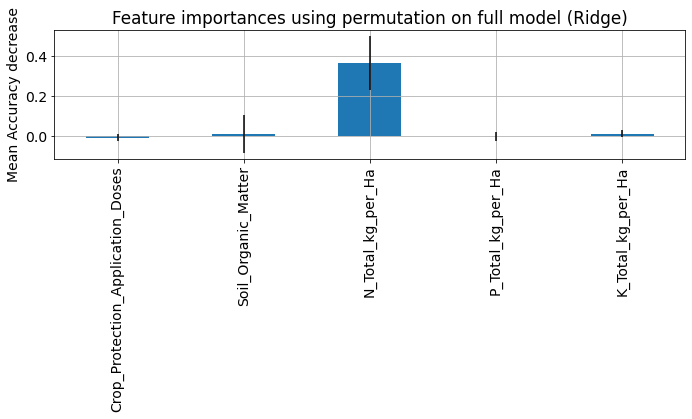

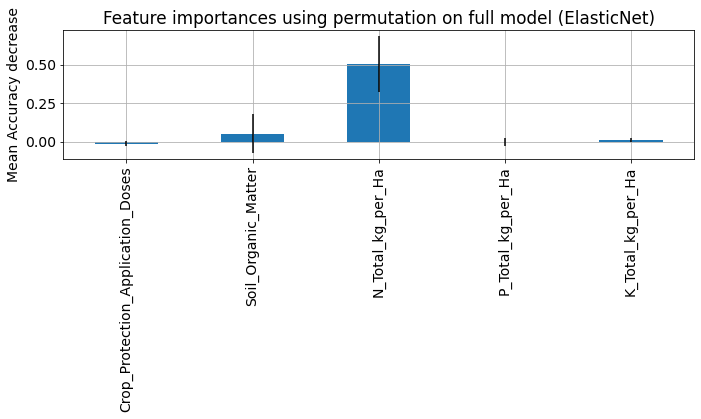

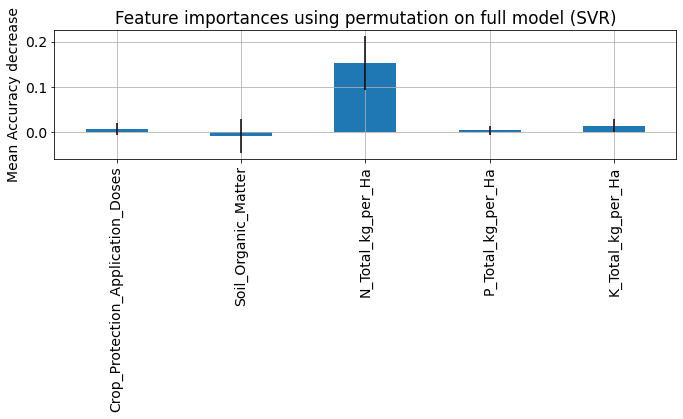

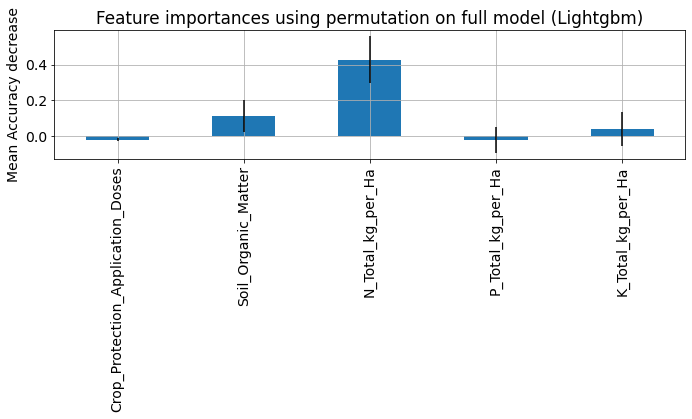

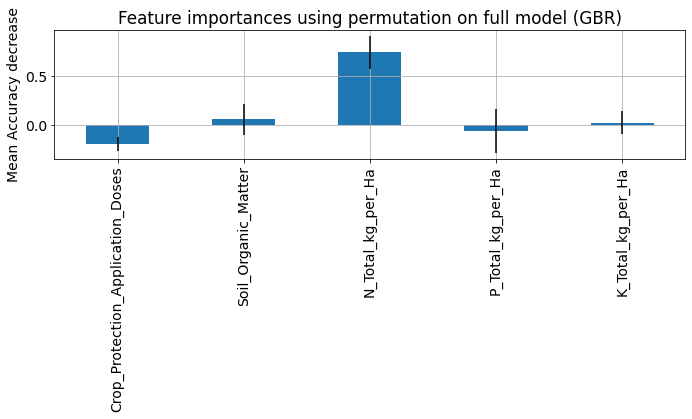

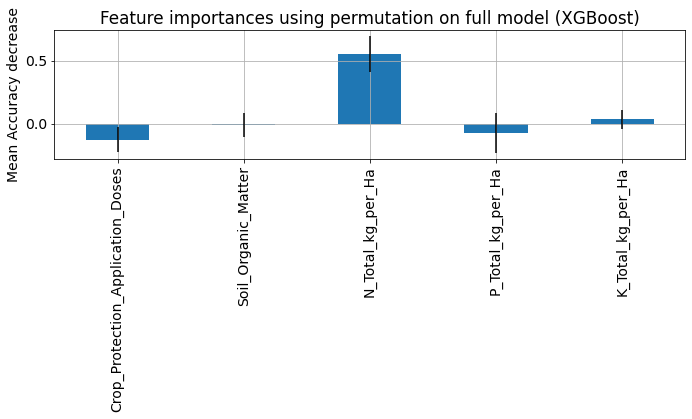

In [42]:
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.8
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)]
df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df0_filtered, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))

for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield to CO2 Ratio)')
    plt.legend()
    plt.show()
    
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [45]:
#exploring macrozones
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.8
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)].reset_index(drop = True)
df0_filtered = df0_filtered[df0_filtered['Macrozone'] == 21]
print(df0_filtered['Macrozone'].value_counts())

21    40
22    34
17    33
7     15
20    10
14     8
15     5
19     4
12     3
30     3
32     2
23     2
29     1
25     1
Name: Macrozone, dtype: int64


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[20:35:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 2.6948853969460536


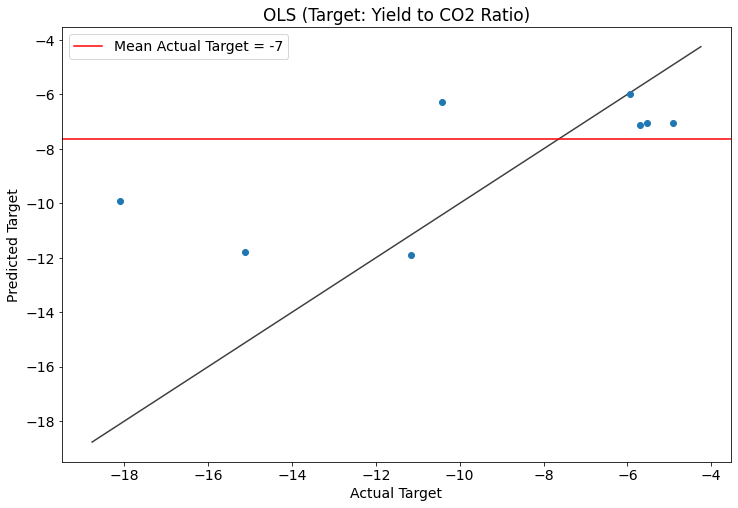

Lasso
MAE on test data: 2.6984265335598945


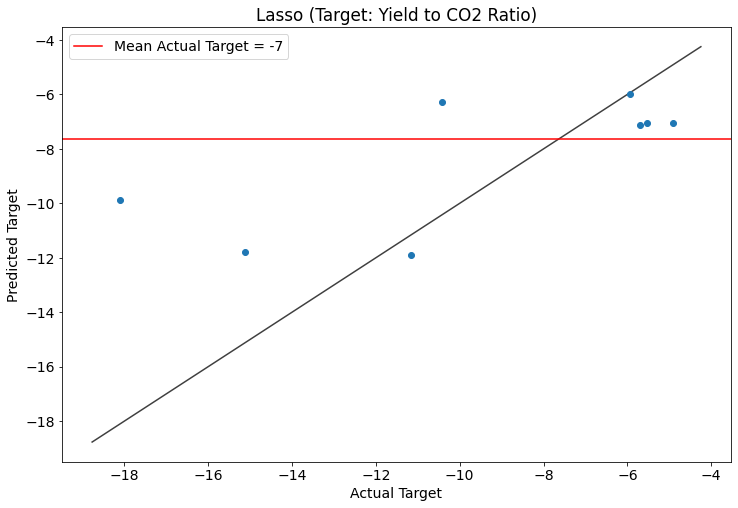

Ridge
MAE on test data: 3.4814485725133757


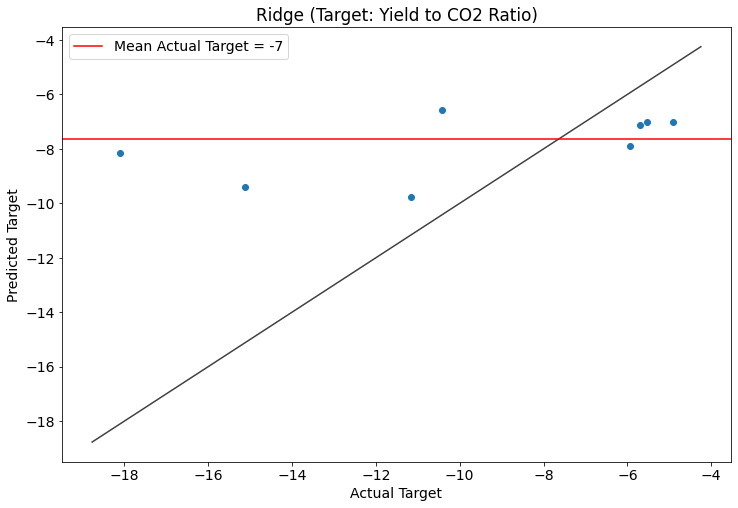

ElasticNet
MAE on test data: 2.6978582000093816


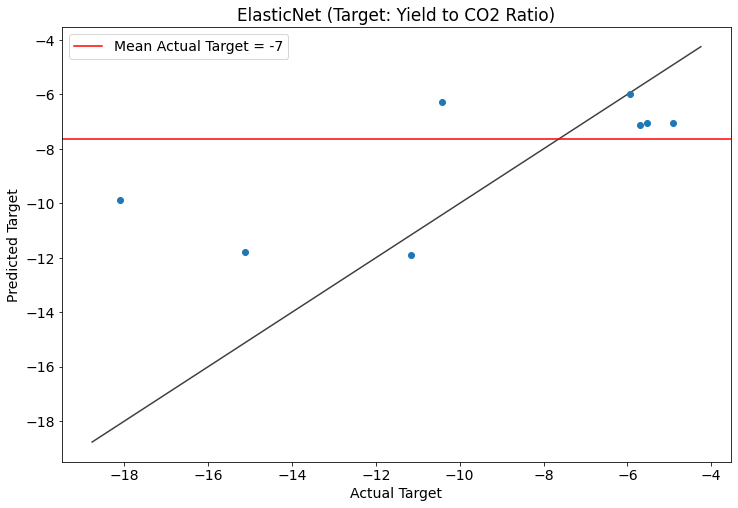

SVR
MAE on test data: 3.970153970589342


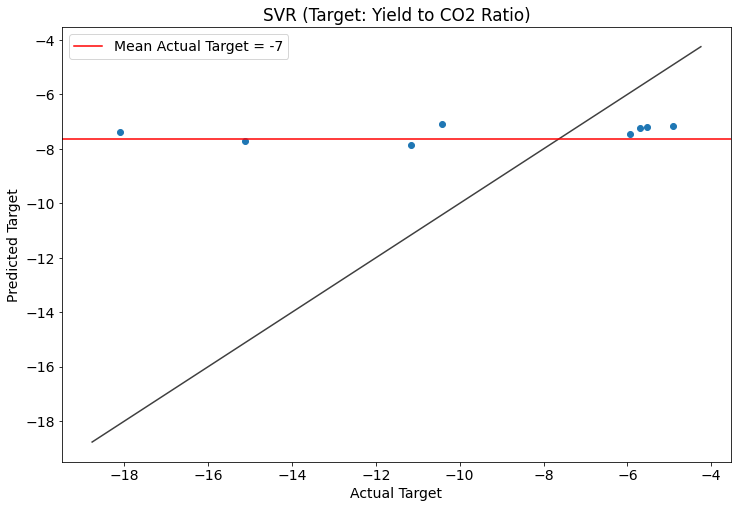

Lightgbm
MAE on test data: 4.091545619281042


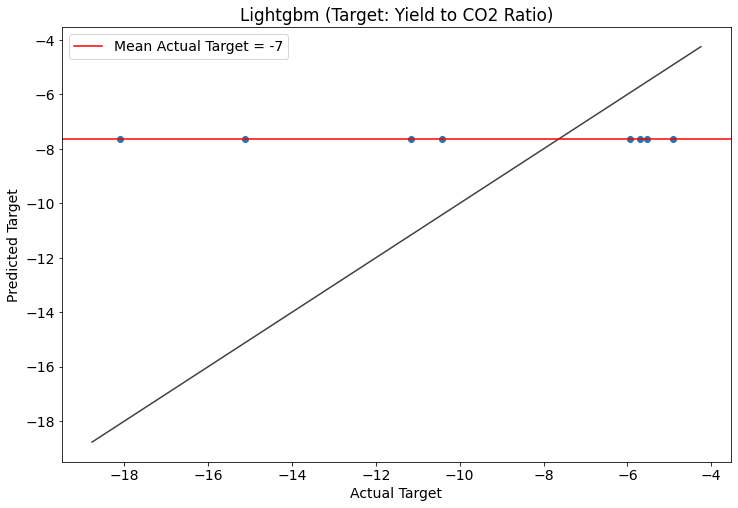

GBR
MAE on test data: 3.748053530759208


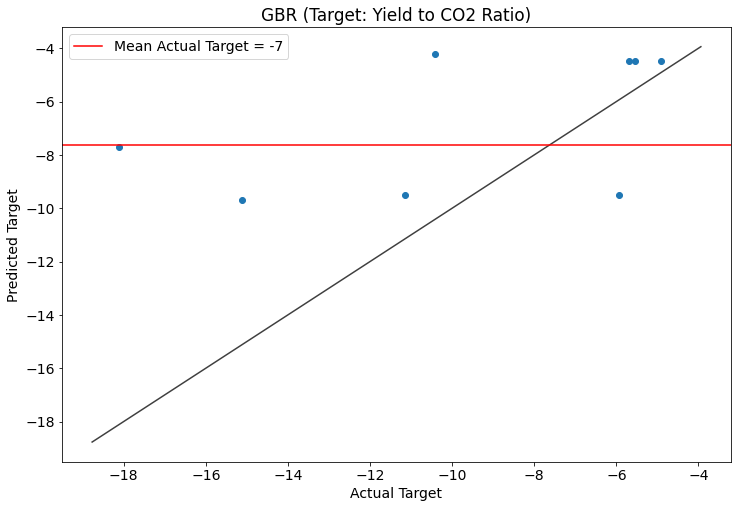

XGBoost
MAE on test data: 2.357584616541724


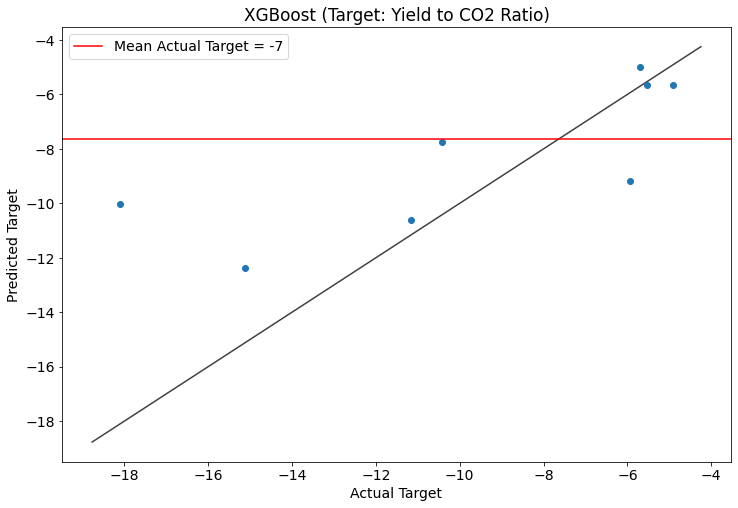

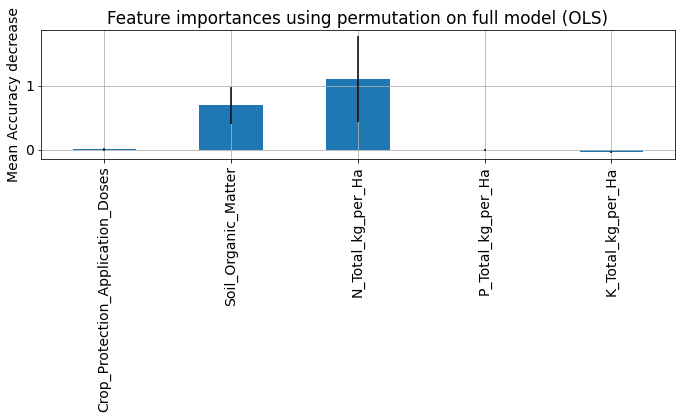

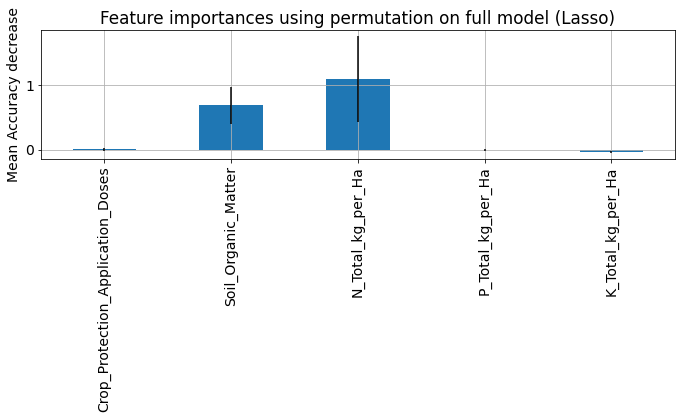

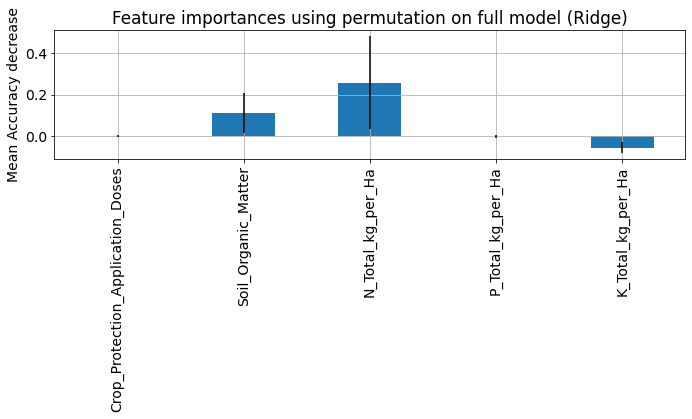

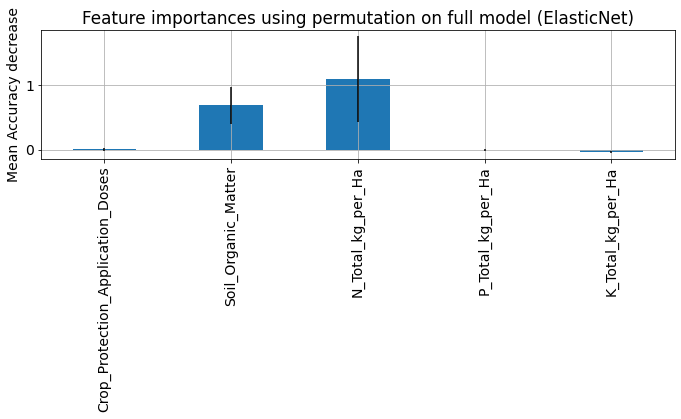

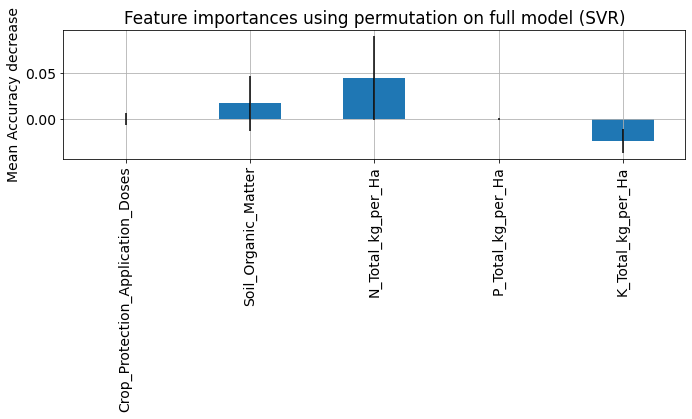

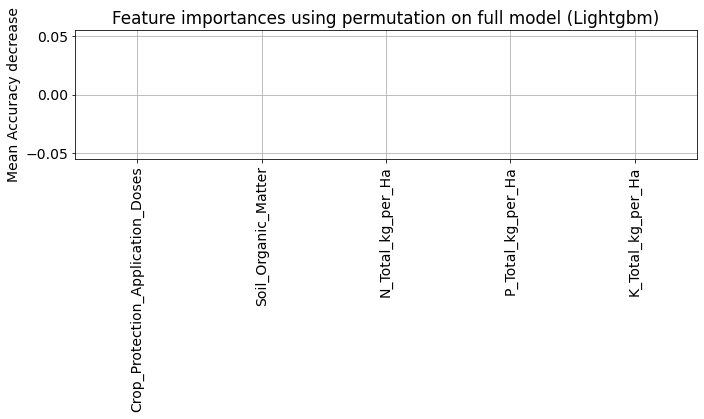

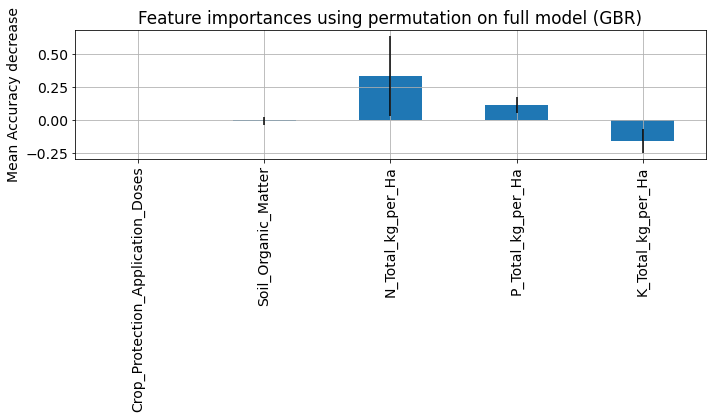

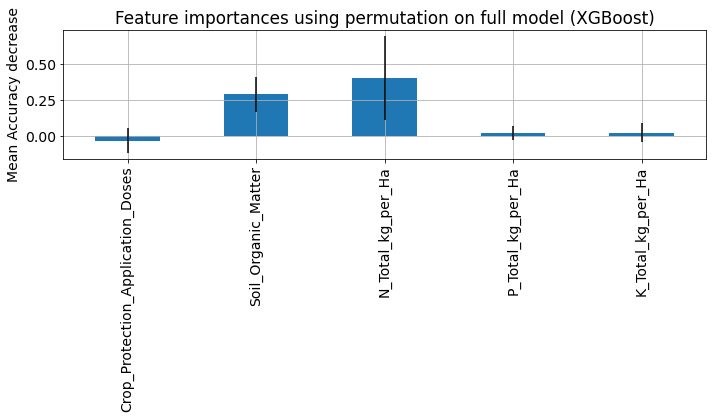

In [46]:
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.8
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)].reset_index(drop = True)
df0_filtered = df0_filtered[df0_filtered['Macrozone'] == 21].reset_index(drop = True)

df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df0_filtered, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))

for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield to CO2 Ratio)')
    plt.legend()
    plt.show()
    
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[20:38:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 4.2766195853605025


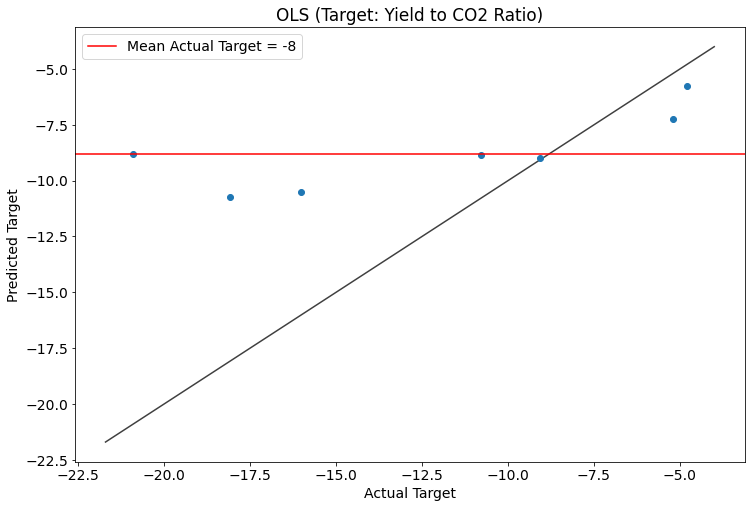

Lasso
MAE on test data: 4.28482196723906


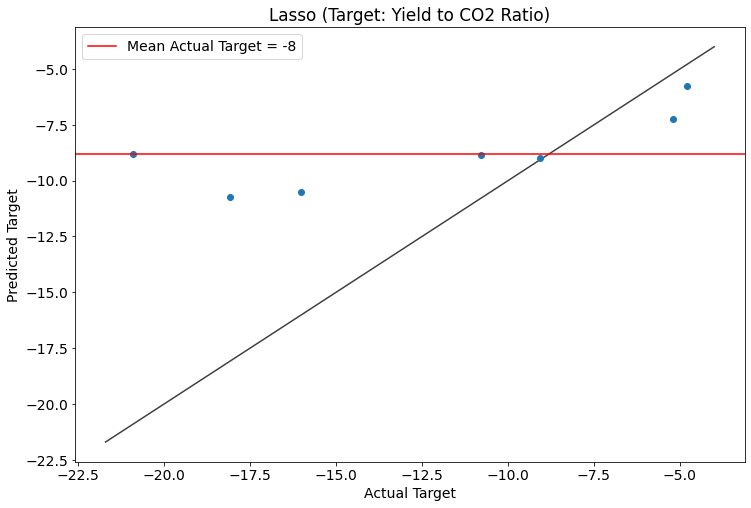

Ridge
MAE on test data: 5.1694201896999346


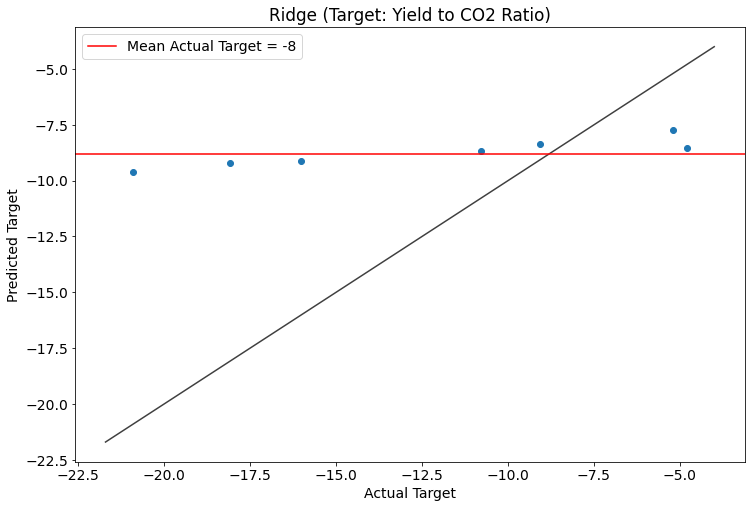

ElasticNet
MAE on test data: 4.283807539428658


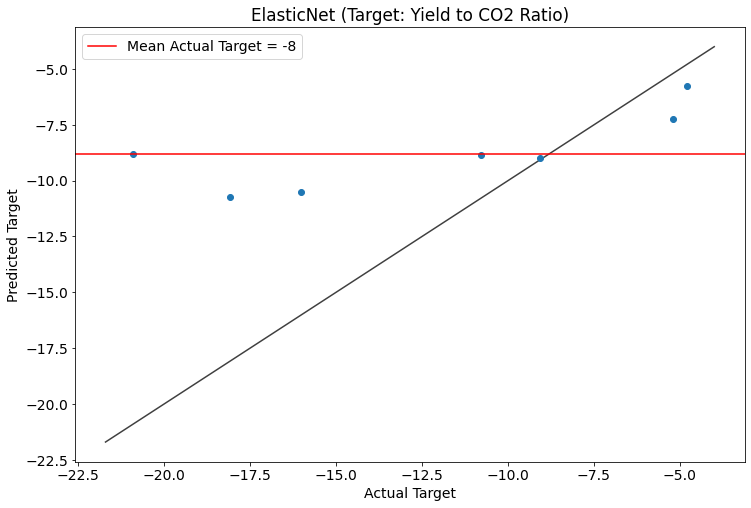

SVR
MAE on test data: 6.226688864205953


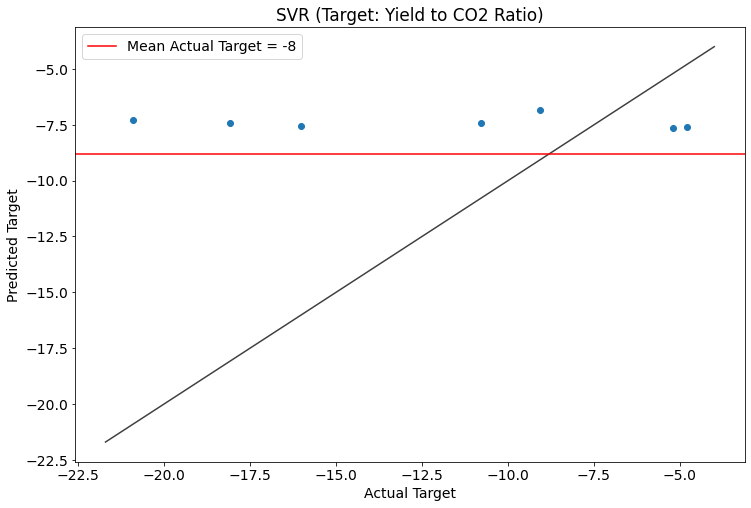

Lightgbm
MAE on test data: 5.49976666072577


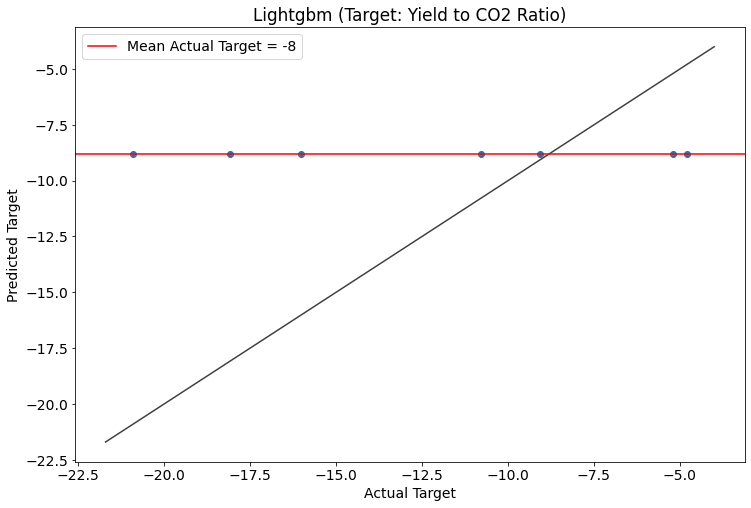

GBR
MAE on test data: 5.648673151466367


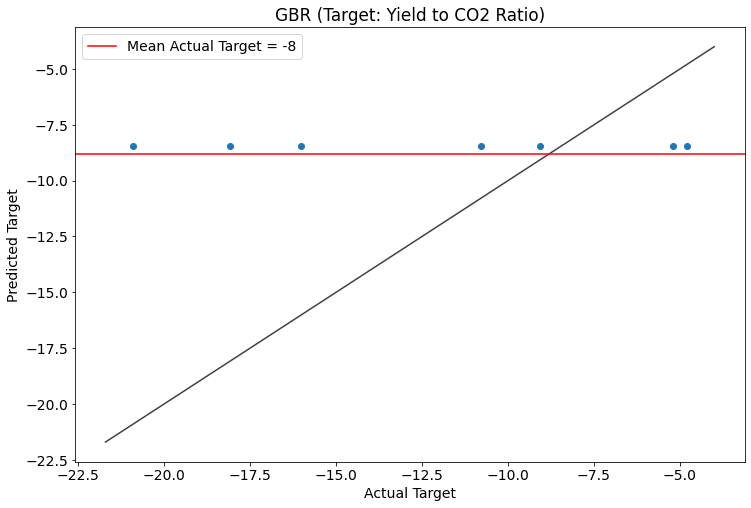

XGBoost
MAE on test data: 3.606106412039537


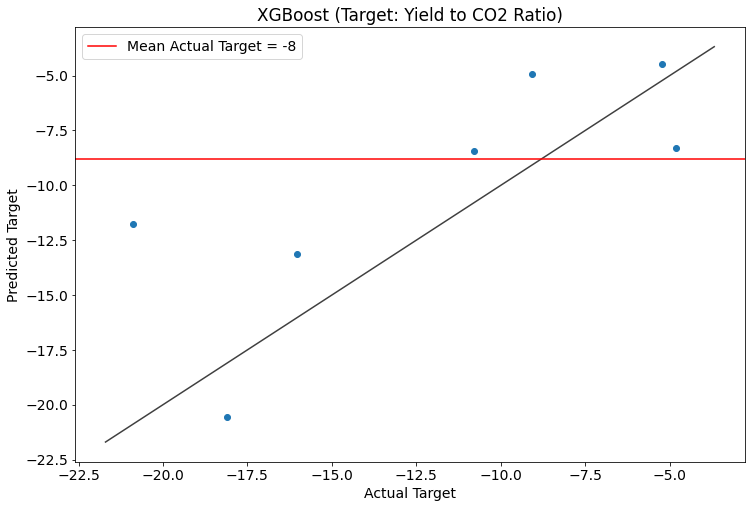

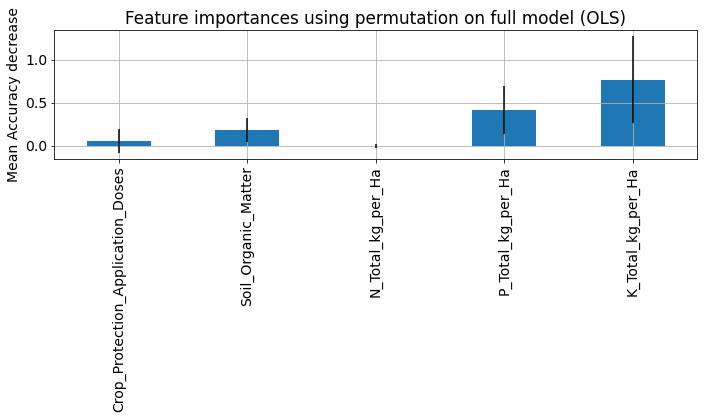

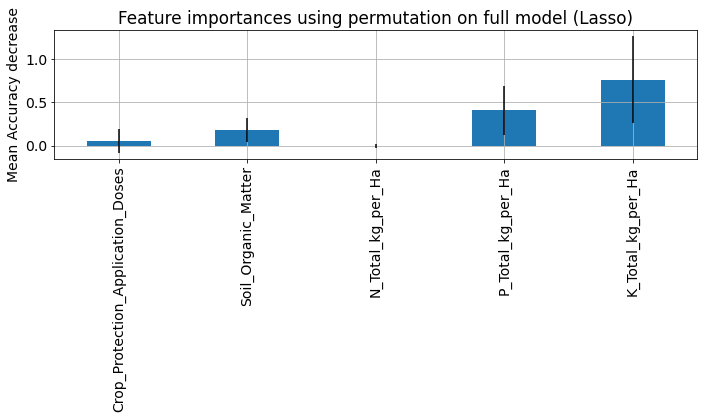

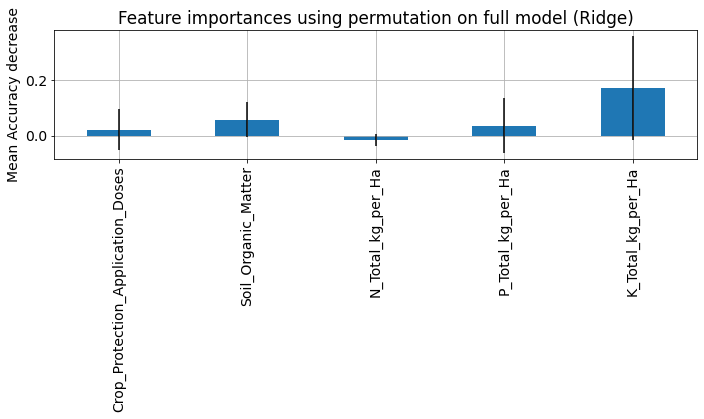

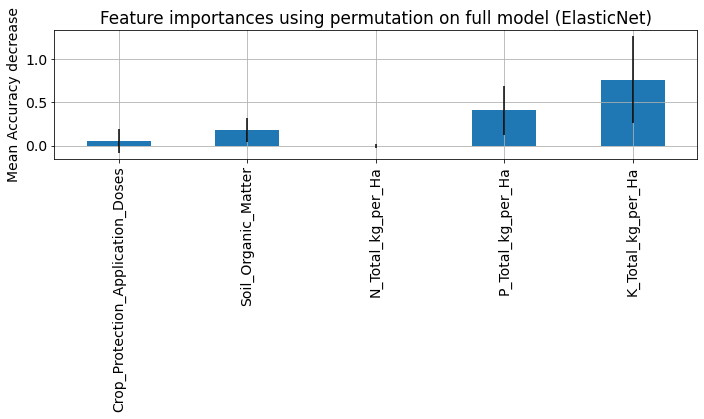

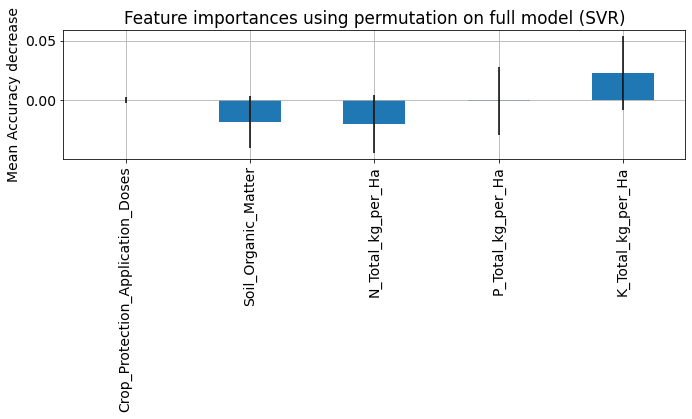

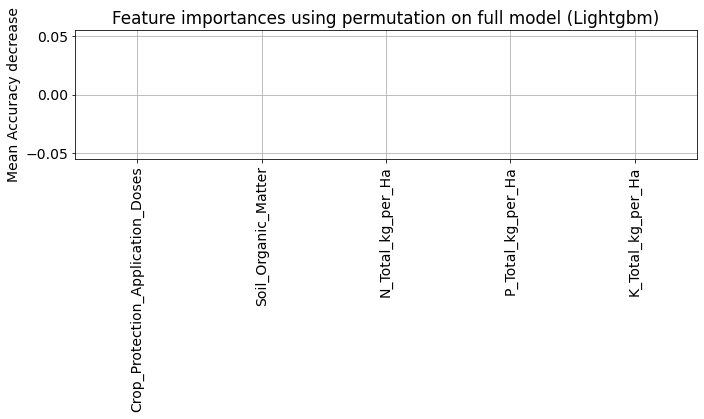

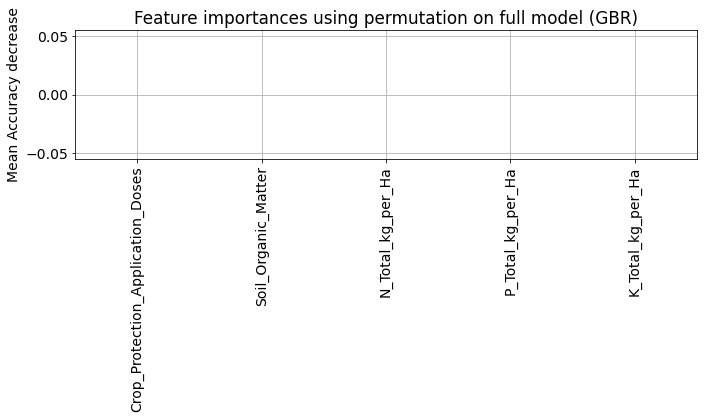

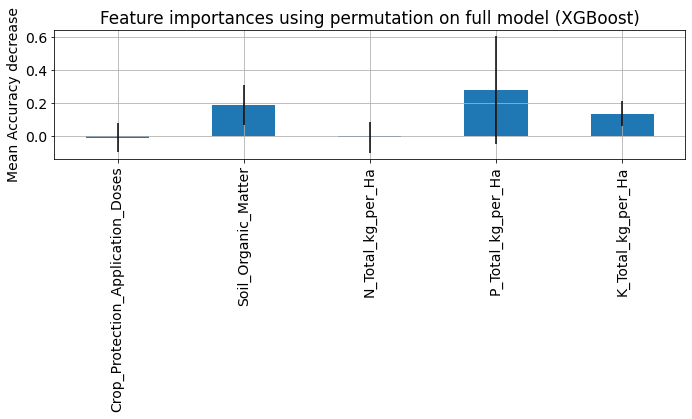

In [47]:
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.8
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)].reset_index(drop = True)
df0_filtered = df0_filtered[df0_filtered['Macrozone'] == 22].reset_index(drop = True)
df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df0_filtered, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))

for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield to CO2 Ratio)')
    plt.legend()
    plt.show()
    
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[20:40:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 3.3737324971317775


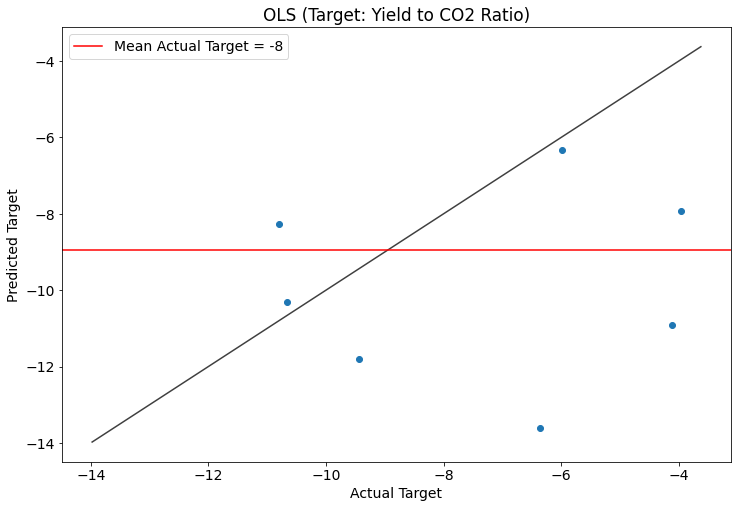

Lasso
MAE on test data: 3.374546602022638


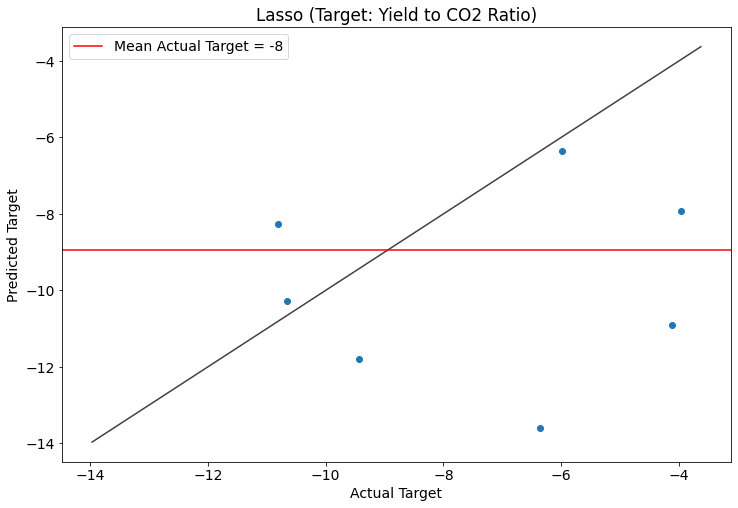

Ridge
MAE on test data: 3.144954498434205


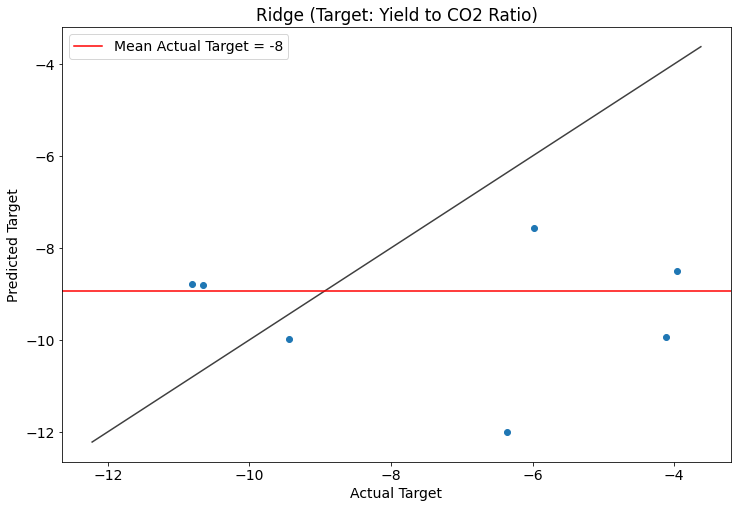

ElasticNet
MAE on test data: 3.3742092997848565


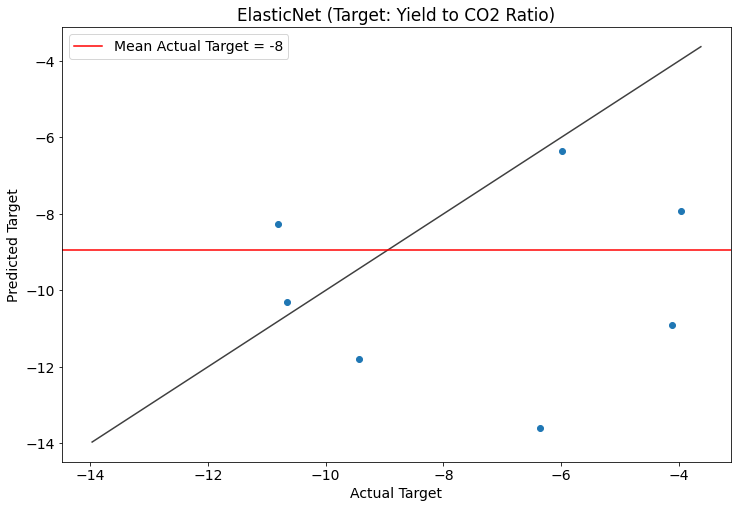

SVR
MAE on test data: 2.850564632300985


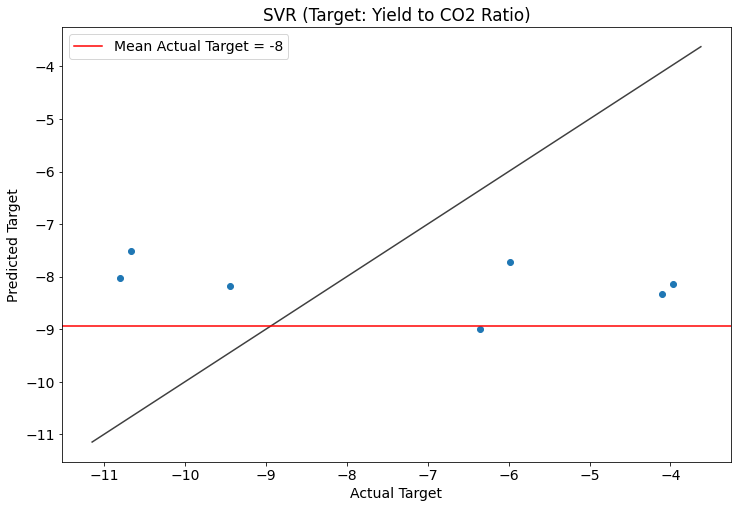

Lightgbm
MAE on test data: 2.7769919263000324


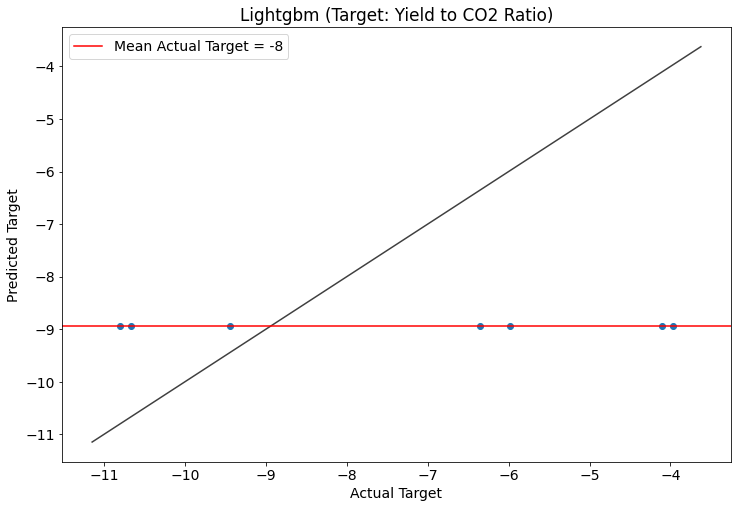

GBR
MAE on test data: 2.735782835983326


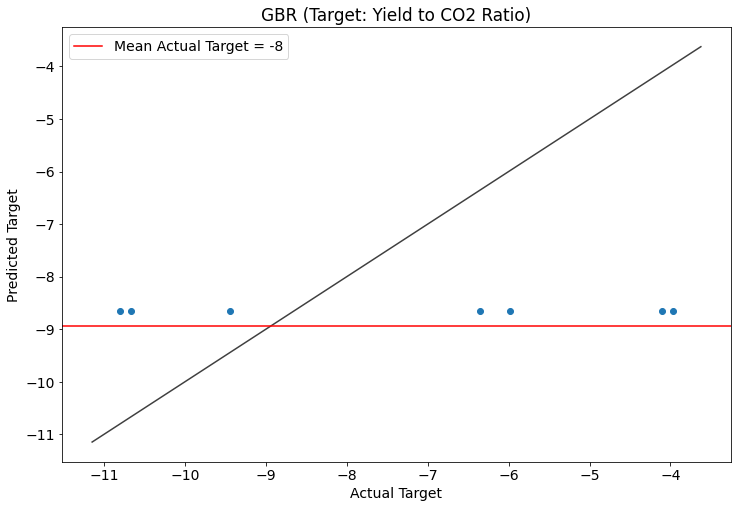

XGBoost
MAE on test data: 2.225268589312472


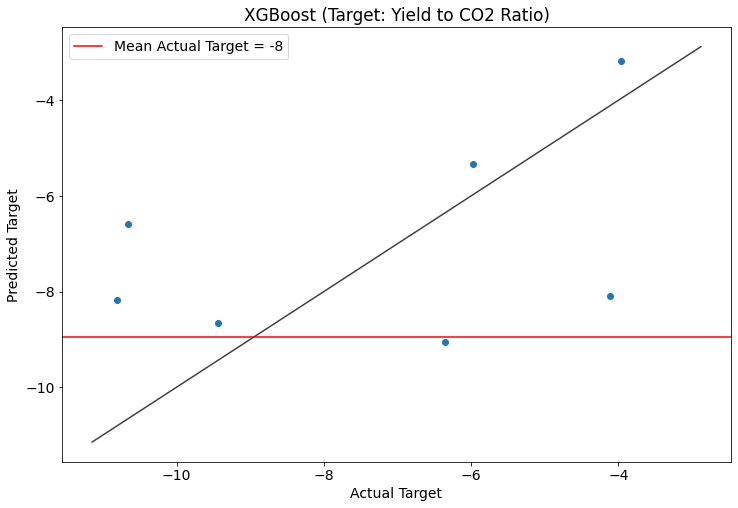

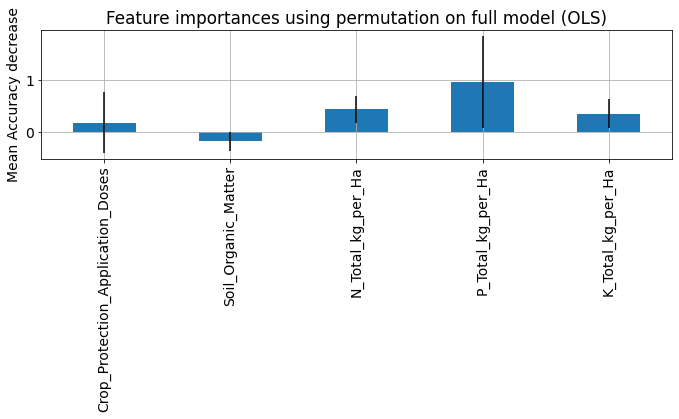

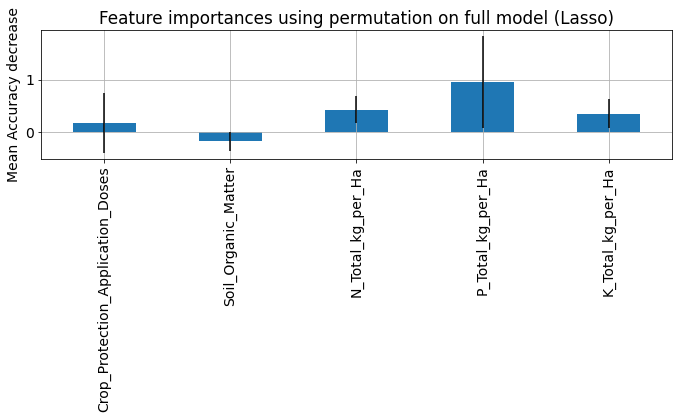

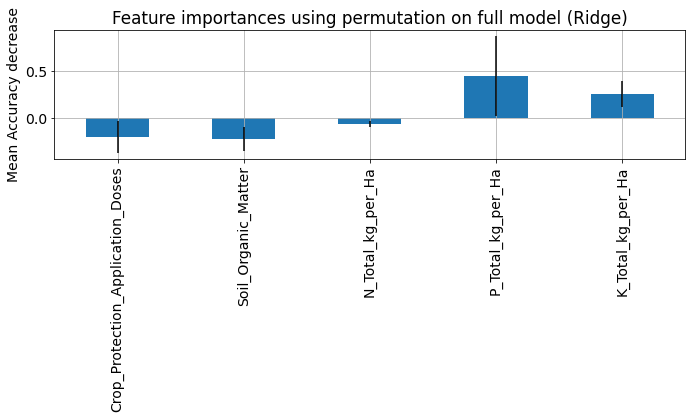

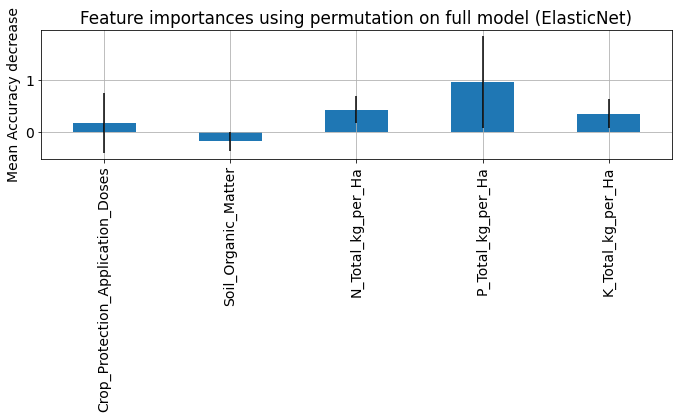

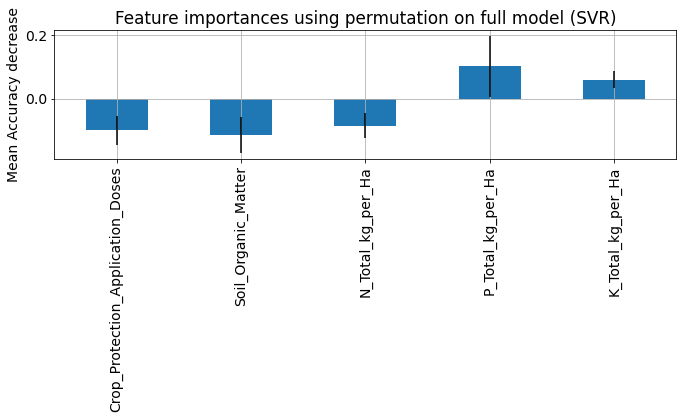

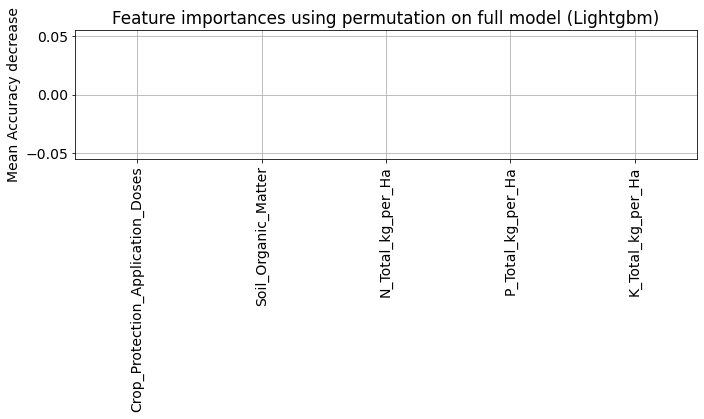

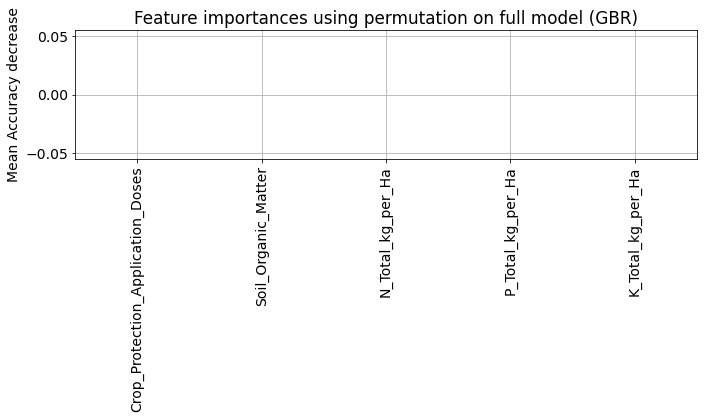

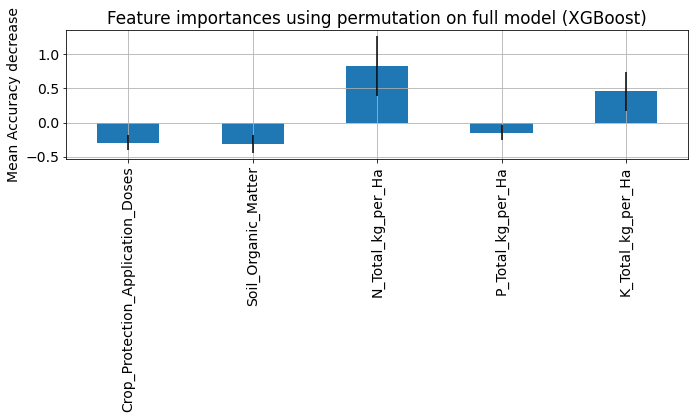

In [48]:
df0 = pd.read_csv("/mnt/Datasets/Brazil_negative_CO2_values_only.csv")
p=.8
q_low = df0["Yield_to_CO2_Ratio"].quantile(1-p)
q_hi  = df0["Yield_to_CO2_Ratio"].quantile(p)
df0_filtered = df0[(df0["Yield_to_CO2_Ratio"] < q_hi) & (df0["Yield_to_CO2_Ratio"] > q_low)].reset_index(drop = True)
df0_filtered = df0_filtered[df0_filtered['Macrozone'] == 17].reset_index(drop = True)
df0_filtered=df0_filtered[["Crop_Protection_Application_Doses", "Soil_Organic_Matter", "N_Total_kg_per_Ha", "P_Total_kg_per_Ha", "K_Total_kg_per_Ha", "Yield_to_CO2_Ratio"]]

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df0_filtered, test_size = 0.2, random_state = 60)

#x values
X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])
X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio'])

standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)

X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)

#y_values
y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()

y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_to_CO2_Ratio']).reshape(-1, 1)

standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))

y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)

y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)

####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))

for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(y_test_Yield_kg_per_ha)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield to CO2 Ratio)')
    plt.legend()
    plt.show()
    
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = train_Yield_kg_per_ha.drop(columns = ['Yield_to_CO2_Ratio']).columns

    result = permutation_importance(
        fitted_models[i], X_test_Yield_kg_per_ha, y_test_Yield_kg_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()